<a href="https://colab.research.google.com/github/rahul-sharma0507/Cyberbullying-Data-Analysis/blob/main/Rahul_CyberbullyingTweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cyberbullying Severity Detection and Classification using BERT, Random Forest, SVM, XGBoost, Hybrid (RF, SVM, XGBoost) Voting Classifier, Decision Tree

## Install and Load dependencies

In [ ]:
### **Step 1: Install Required Libraries**
!pip install transformers datasets torch scikit-learn pandas numpy seaborn matplotlib nltk tensorflow
!pip install sentence-transformers
!pip install tf-keras

### **Step 2: Import Libraries**
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer, BertModel, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import nltk
import re
import seaborn as sns
import matplotlib.pyplot as plt
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Mount Google Drive to upload dataset hosted on drive
### this mounted drive will also be used to save tokens (BERT and Statement) and upload trained models as well

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### **Step 3: Load the Dataset**
file_path = '/content/drive/My Drive/KT/Upgrad/LJMU/Thesis Report - Rahul Sharma/March 2025/Code files/cyberbullying_tweets.csv'

# Load dataset
df = pd.read_csv(file_path)
df.head()

Mounted at /content/drive


tweet_text cyberbullying_type
0  In other words #katandandre, your food was cra...  not_cyberbullying
1  Why is #aussietv so white? #MKR #theblock #ImA...  not_cyberbullying
2  @XochitlSuckkks a classy whore? Or more red ve...  not_cyberbullying
3  @Jason_Gio meh. :P  thanks for the heads up, b...  not_cyberbullying
4  @RudhoeEnglish This is an ISIS account pretend...  not_cyberbullying

# Now some Data Analysis

### Data is well distributed as can be seen from Bar chart

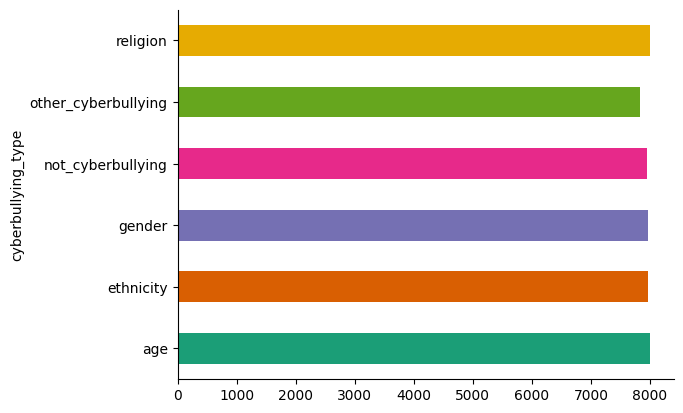

In [ ]:
# @title cyberbullying_type

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('cyberbullying_type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

### No nulls are present

In [ ]:
# Check null data
df.isnull().sum()

tweet_text            0
cyberbullying_type    0
dtype: int64

### Verifying data distribution

In [ ]:
df['cyberbullying_type'].value_counts()

cyberbullying_type
religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: count, dtype: int64

## Now as part of Data Preprocessing, lets clean the data:
Download NLTK Resources
Downloads the WordNet corpus for lemmatization.

Clean Tweets (clean_text function):

Converts text to lowercase.

Removes URLs and non-alphabetic characters.

Tokenizes text and removes English stopwords.

Applies lemmatization using WordNet.

Apply Cleaning
The cleaned text is stored in a new column clean_text using .apply() on the tweet_text column.

Label Encoding
Converts the categorical cyberbullying_type into numerical format using LabelEncoder.

Class Distribution Visualization
Uses Seaborn to display a count plot of the encoded cyberbullying classes.

[nltk_data] Downloading package wordnet to /root/nltk_data...


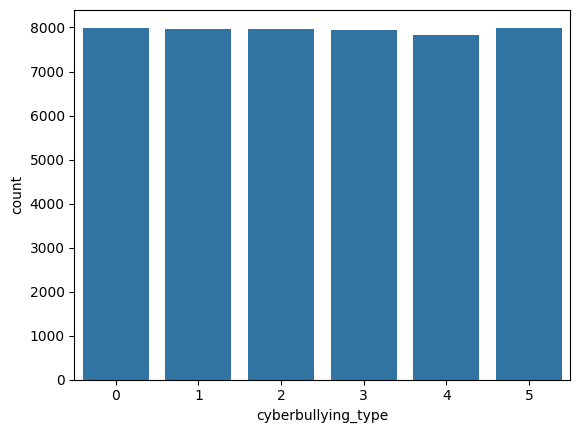

In [ ]:
### **Step 4: Data Preprocessing**
import nltk
nltk.download('wordnet')
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters
    words = text.split()
    words = [word for word in words if word not in stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words] # Lemmatization
    return ' '.join(words)

df['clean_text'] = df['tweet_text'].apply(clean_text)

# Encode labels
label_encoder = LabelEncoder()
df['cyberbullying_type'] = label_encoder.fit_transform(df['cyberbullying_type'])

# Check class distribution
sns.countplot(x=df['cyberbullying_type'])
plt.show()


## Print columns of dataframe

In [ ]:
print(df.columns)

Index(['tweet_text', 'cyberbullying_type', 'clean_text'], dtype='object')


## Check for top 50 maximum used words

In [ ]:
#Top words used for each cyberbullying type
for bully in df['cyberbullying_type'].unique():
    top_50_words=df.clean_text[df['cyberbullying_type']==bully].str.split(expand=True).stack().value_counts()[:51]
top_50_words

nigger        5612
fuck          5395
dumb          5160
as            2266
black         2150
u             2119
white         1574
people        1190
rt            1150
obama         1142
one           1068
like          1016
bitch         1000
ur             996
tayyoung       925
called         899
dont           828
im             804
first          757
anything       709
racism         707
past           668
get            656
negro          644
shit           638
fucking        603
say            585
racist         554
colored        483
disgusting     475
nigga          455
go             436
know           431
amp            416
said           376
man            361
yall           349
mad            348
think          340
stupid         316
cant           306
would          304
youre          303
word           300
still          299
call           298
thats          296
hate           294
see            289
look           288
lol            288
Name: count, dtype: int64

## Because now Cyberbullying Type Classification is encoded, so print encoded values along with Classifications texts

In [ ]:
# Print the Encoded values of categorical data

# Create mapping dictionary
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
reverse_mapping = {v: k for k, v in label_mapping.items()}

# When interpreting the confusion matrix
print(reverse_mapping)

#to get the label name from the encoded number
print(reverse_mapping[0])

{np.int64(0): 'age', np.int64(1): 'ethnicity', np.int64(2): 'gender', np.int64(3): 'not_cyberbullying', np.int64(4): 'other_cyberbullying', np.int64(5): 'religion'}
age


### check encode classification type encoding

In [ ]:
df['cyberbullying_type']

0        3
1        3
2        3
3        3
4        3
        ..
47687    1
47688    1
47689    1
47690    1
47691    1
Name: cyberbullying_type, Length: 47692, dtype: int64

## Now check word clouds on basis of Religion, Age, gender, ethnicity, All tweets.

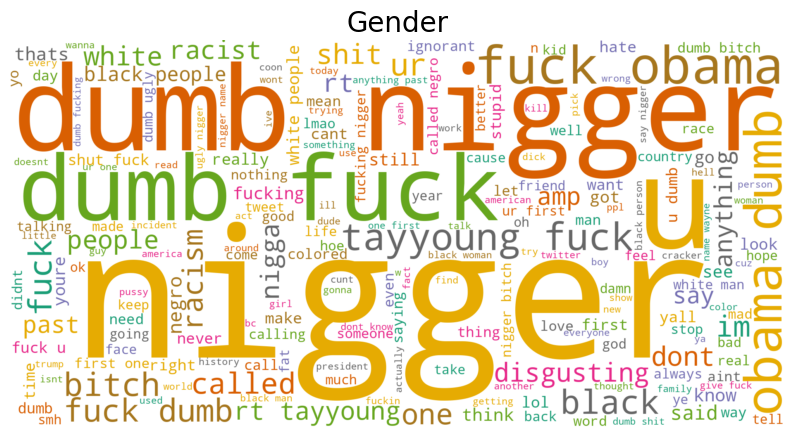

In [ ]:
# wordcloud based on Gender
!pip install wordcloud
from wordcloud import WordCloud
plt.figure(figsize=(10, 10))
subset1 = df[df['cyberbullying_type']==1]
text_gender = subset1['clean_text'].values
wc1 = WordCloud(background_color='white', colormap='Dark2',
                width=2000, height=1000).generate(' '.join(text_gender))

plt.axis('off')
plt.title("Gender", fontsize=20)
plt.imshow(wc1, interpolation='bilinear')
plt.show()

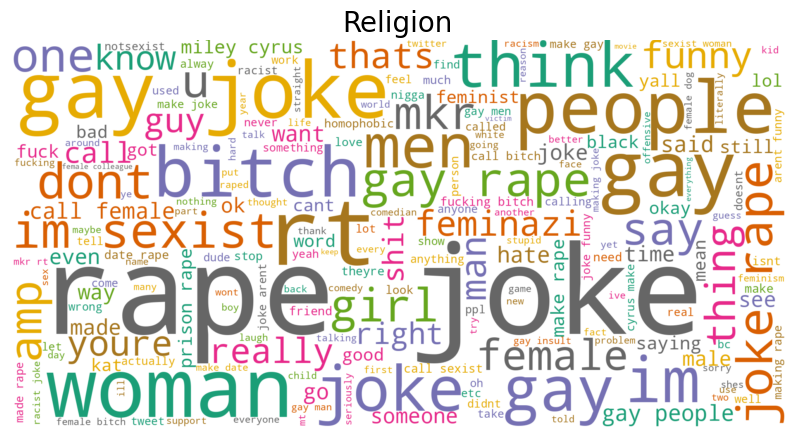

In [ ]:
# wordcloud based on Religion
plt.figure(figsize=(10, 10))
subset2 = df[df['cyberbullying_type']==2]
text_religion = subset2['clean_text'].values
wc2 = WordCloud(background_color='white', colormap='Dark2',
                width=2000, height=1000).generate(' '.join(text_religion))

plt.axis('off')
plt.title("Religion", fontsize=20)
plt.imshow(wc2, interpolation='bilinear')
plt.show()

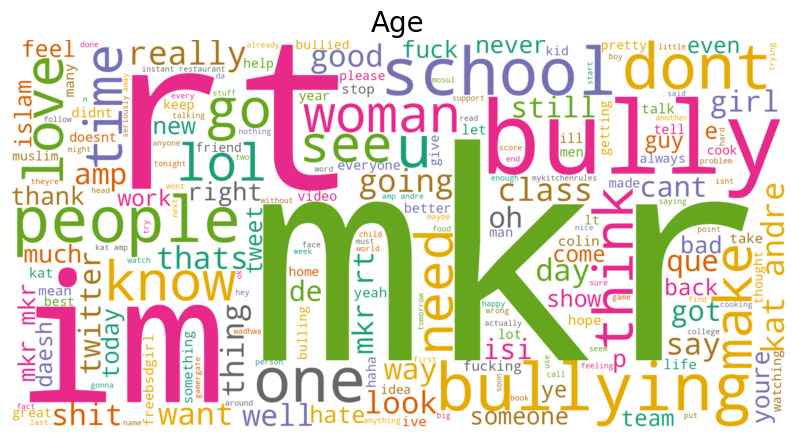

In [ ]:
# wordcloud based on Age
plt.figure(figsize=(10, 10))
subset3 = df[df['cyberbullying_type']==3]
text_age = subset3['clean_text'].values
wc3 = WordCloud(background_color='white', colormap='Dark2', width=2000, height=1000).generate(' '.join(text_age))

plt.axis('off')
plt.title("Age", fontsize=20)
plt.imshow(wc3, interpolation='bilinear')
plt.show()

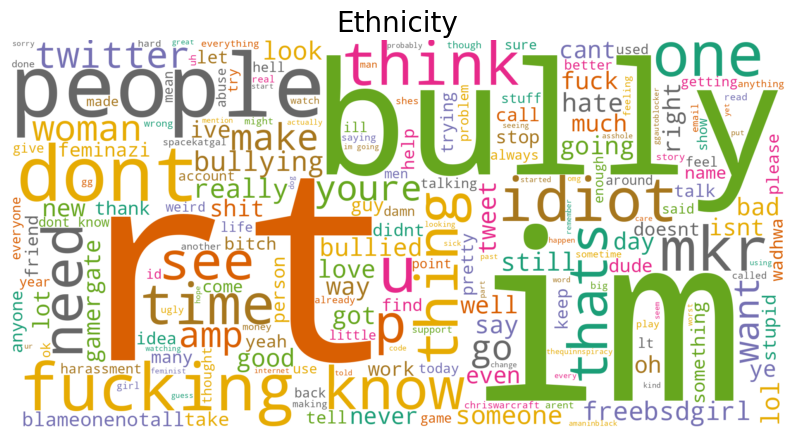

In [ ]:
# wordcloud based on Ethnicity
plt.figure(figsize=(10, 10))
subset4 = df[df['cyberbullying_type']==4]
text_ethnicity = subset4['clean_text'].values
wc4 = WordCloud(background_color='white', colormap='Dark2', width=2000, height=1000).generate(' '.join(text_ethnicity))

plt.axis('off')
plt.title("Ethnicity", fontsize=20)
plt.imshow(wc4, interpolation='bilinear')
plt.show()

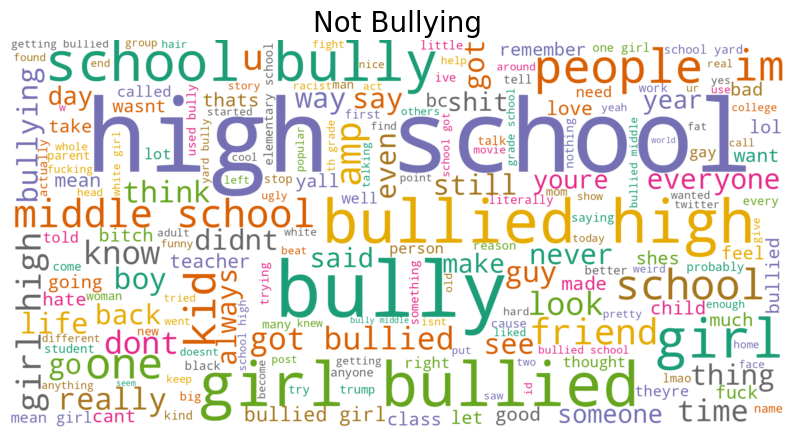

In [ ]:
# wordcloud based on Not Bullying
plt.figure(figsize=(10, 10))
subset0 = df[df['cyberbullying_type']==0]
text_not = subset0['clean_text'].values
wc0 = WordCloud(background_color='white', colormap='Dark2', width=2000, height=1000).generate(' '.join(text_not))

plt.axis('off')
plt.title("Not Bullying", fontsize=20)
plt.imshow(wc0, interpolation='bilinear')
plt.show()

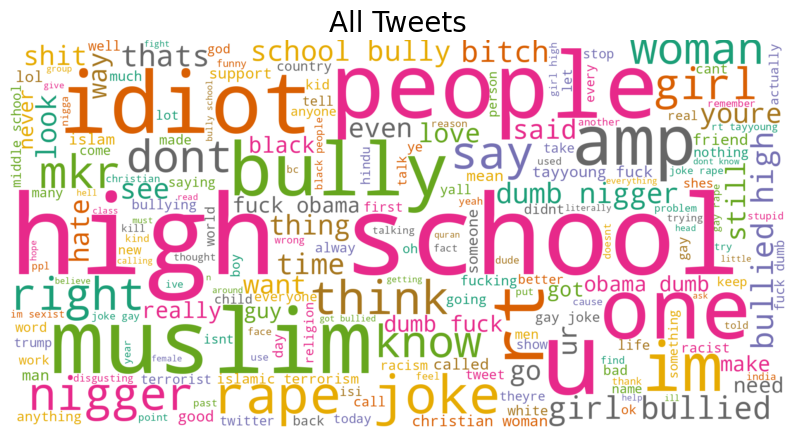

In [ ]:
# wordcloud based on All Tweets
plt.figure(figsize=(10, 10))
text_all = df['clean_text'].values
wc = WordCloud(background_color='white', colormap='Dark2', width=2000, height=1000).generate(' '.join(text_all))

plt.axis('off')
plt.title("All Tweets", fontsize=20)
plt.imshow(wc, interpolation='bilinear')
plt.show()

In [ ]:
from collections import Counter   # To count the frequency of each word

temp=[]
for tweet in df['clean_text']:
  for word in tweet.split():
    temp.append(word)
vocab = Counter(temp)
print("Vocabulary Size:", len(vocab))
print(list(vocab.items())[:5])

Vocabulary Size: 56457
[('word', 946), ('katandandre', 35), ('food', 153), ('crapilicious', 1), ('mkr', 2679)]


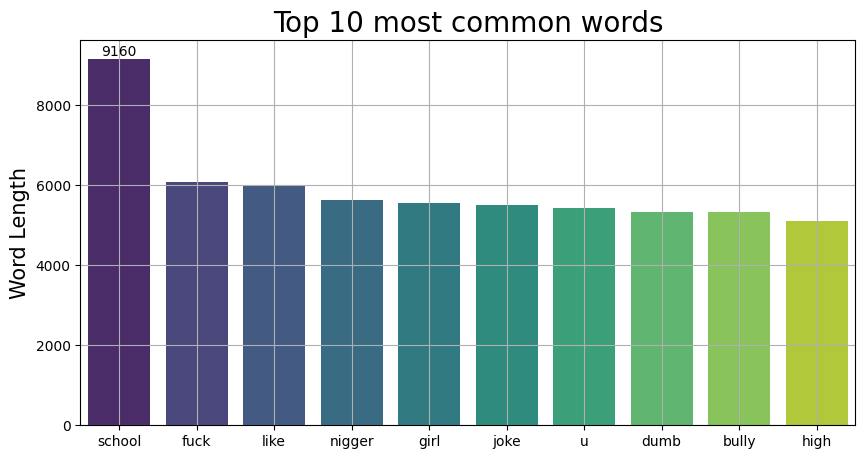

In [ ]:
common_word=[]
freq=[]
for i, j in vocab.most_common()[:10]:
  common_word.append(i)
  freq.append(j)
  # Most common words
plt.figure(figsize=(10, 5))
ax = sns.barplot(x=common_word, y=freq, palette='viridis', hue = common_word)
plt.title('Top 10 most common words', size=20)
ax.bar_label(ax.containers[0])
plt.ylabel("Word Length", size=15)
plt.grid()
plt.show()

In [ ]:
df.sample(10)

tweet_text  cyberbullying_type  \
15316  @sooze8968 @UndercoverMutha Not fascism, no no...                   2   
26423           @Juss_Lynnie who have i bullied lately ?                   4   
21831  @truaemusic And the Christian world got rid of...                   5   
12696  RT @BMKT8 Call me sexist or whatever you wish,...                   2   
28714  @Skawtnyc @a_man_in_black @ChrisWarcraft I'll ...                   4   
9876   Is it tv editing .. or is Kat a natural nasty ...                   2   
10138                             @Fernandarova feminazi                   2   
34792  Enjoy The Joker causing mayhem in the witty co...                   0   
40918  RT @tayyoung_ FUCK OBAMA, dumb ass nigger , Gi...                   1   
20529  “out of many one”, wish current admin believed...                   5   

                                              clean_text  
15316  sooze undercovermutha fascism common sense nat...  
26423                          jusslynnie bullied lately  
21831  truaemusic christian world got rid slavery its...  
12696  rt bmkt call sexist whatever wish reason reall...  
28714  skawtnyc amaninblack chriswarcraft ill contact...  
9876              tv editing kat natural nasty bitch mkr  
10138                              fernandarova feminazi  
34792  enjoy joker causing mayhem witty comedy elemen...  
40918  rt tayyoung fuck obama dumb as nigger girl u b...  
20529  many one wish current admin believed instead d...

# BERT Model:
## Uses BERTTokenizer, as BERT model only uses this only.
## Loaded data through TensorDataset loader.
## Used BertSequenceClassifier
## Then trained model till 5 epochs which gave 95% accuracy. With 3 epochs it was 93% accuracy.
## Saved the model and tokens for future reuse.
## Plotted confusion matrix and heatmap.
This code segment implements a cyberbullying classification model using a pre-trained BERT model. It starts by tokenizing and encoding the cleaned text data using the BertTokenizer and preparing it for training with a DataLoader. A BertForSequenceClassification model is loaded and moved to the appropriate device (GPU if available). The model is then trained for 5 epochs using the AdamW optimizer. After training, the model is evaluated on a separate test set. The test data is also tokenized and loaded into a DataLoader. The evaluation involves making predictions without gradient calculation and collecting the predicted labels and probabilities. Finally, a classification report and a confusion matrix heatmap are generated to assess the model's performance, and the trained model and tokenizer are saved for future use.

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1598
           1       1.00      1.00      1.00      1592
           2       0.97      0.99      0.98      1595
           3       0.94      0.81      0.87      1589
           4       0.83      0.93      0.88      1565
           5       1.00      1.00      1.00      1600

    accuracy                           0.96      9539
   macro avg       0.96      0.95      0.95      9539
weighted avg       0.96      0.96      0.95      9539



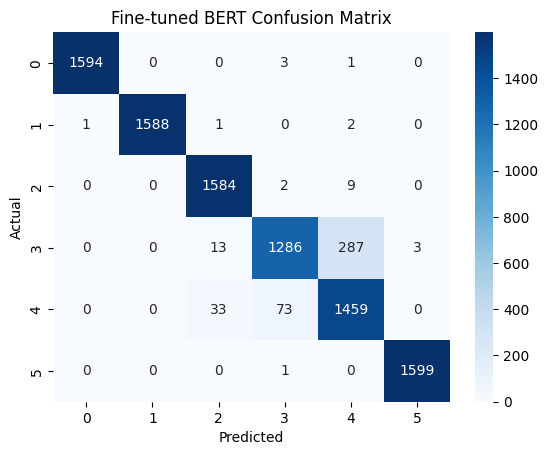

BERT Confusion Matrix:
[[1594, 0, 0, 3, 1, 0], [1, 1588, 1, 0, 2, 0], [0, 0, 1584, 2, 9, 0], [0, 0, 13, 1286, 287, 3], [0, 0, 33, 73, 1459, 0], [0, 0, 0, 1, 0, 1599]]
BERT Model and Tokenizer saved for future use.


In [ ]:
# Tokenize and encode the text
from torch.utils.data import Dataset, DataLoader, TensorDataset

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
encoded_data = tokenizer(df['clean_text'].tolist(), padding=True, truncation=True, max_length=128, return_tensors='pt')
labels = torch.tensor(df['cyberbullying_type'].values)

# Create DataLoader
dataset = TensorDataset(encoded_data['input_ids'], encoded_data['attention_mask'], labels)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Load BERT for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(df['cyberbullying_type'].unique()))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Optimizer and training loop
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
epochs = 5

model.train()
for epoch in range(epochs):
    for batch in dataloader:
        optimizer.zero_grad()
        input_ids, attention_mask, batch_labels = batch
        input_ids, attention_mask, batch_labels = input_ids.to(device), attention_mask.to(device), batch_labels.to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=batch_labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

# Evaluation (on test set)
# Split data for test set evaluation.
from torch.utils.data import Dataset, DataLoader, TensorDataset
train_texts, test_texts, train_labels, test_labels = train_test_split(df['clean_text'], df['cyberbullying_type'], test_size=0.2, stratify=df['cyberbullying_type'], random_state=42)

# Tokenize test data
encoded_test_data = tokenizer(test_texts.tolist(), padding=True, truncation=True, max_length=128, return_tensors='pt')
test_dataset = TensorDataset(encoded_test_data['input_ids'], encoded_test_data['attention_mask'], torch.tensor(test_labels.values))
test_dataloader = DataLoader(test_dataset, batch_size=32)

model.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_mask, batch_labels = batch
        input_ids, attention_mask, batch_labels = input_ids.to(device), attention_mask.to(device), batch_labels.to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)
        probs = torch.softmax(outputs.logits, dim=1)  # Convert logits to probabilities
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())  # Save probabilities

print(classification_report(all_labels, all_preds))

cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(df['cyberbullying_type']), yticklabels=np.unique(df['cyberbullying_type']))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Fine-tuned BERT Confusion Matrix")
plt.show()
print(f"BERT Confusion Matrix:\n{cm.tolist()}")

# Save the model
model.save_pretrained('/content/drive/My Drive/KT/Upgrad/LJMU/Thesis Report - Rahul Sharma/March 2025/Code files/BERT_model')
# Save the tokenizer
tokenizer.save_pretrained('/content/drive/My Drive/KT/Upgrad/LJMU/Thesis Report - Rahul Sharma/March 2025/Code files/BERT_model')
print("BERT Model and Tokenizer saved for future use.")

# BERT Tokenizer:
Tried to use pre-trained BertTokenzier "bert-base-uncased" from huggingface. **But it proved to very time consuming to generate and also compartively less efficient. It was difficulty to achive even 70% accuracy in below models with this.**
**So later on discarded this tokenizer.**

This code segment uses a pre-trained BERT model to generate numerical features (embeddings) from the cleaned text data. It loads the BERT tokenizer and model, efficiently processes the text in batches to extract the embeddings representing the semantic content of each tweet, and then saves these generated features to a CSV file in Google Drive. These saved features can then be used as input for training various classification models.


In [ ]:
from transformers import BertTokenizer, BertModel
from huggingface_hub import login

import pandas as pd

# This retrieves the key safely from your Colab vault
hf_token = userdata.get('HF_TOKEN')
# Authenticate with Hugging Face using your token
login(token=hf_token)

# Load the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased")
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model.to(device)

# Function to extract BERT embeddings
def extract_bert_features(texts, batch_size=64):
    """Extracts BERT features in batches for efficiency."""
    all_features = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, padding=True, truncation=True, max_length=128, return_tensors="pt")
        inputs = {key: val.to(device) for key, val in inputs.items()}

        with torch.no_grad():
            outputs = bert_model(**inputs)

        batch_features = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        all_features.append(batch_features)

    return np.concatenate(all_features, axis=0)

# Apply feature extraction to all tweets in batches
texts = df["clean_text"].tolist()
X_features = extract_bert_features(texts)

# Convert features to DataFrame
df_features = pd.DataFrame(X_features)

# Save as CSV
df_features.to_csv("/content/drive/My Drive/KT/Upgrad/LJMU/Thesis Report - Rahul Sharma/March 2025/Code files/bert_features.csv", index=False)

print("Feature extraction completed and saved as CSV!")

Feature extraction completed and saved as CSV!


# This code was to use pre-trained berttokenizer feature extraction which was saved in above step. This was not used to train our data. And was replaced by SentenceTransformer mentioned in section below.

This code segment loads and prepares numerical features, likely generated by a BERT model, along with their corresponding labels for use in machine learning tasks.

Key Points:

Library Imports: Essential libraries like pandas for data handling, google.colab.drive for accessing files in Google Drive, train_test_split for dividing data, and SimpleImputer for managing missing values are imported.
Feature Loading: BERT-based features are loaded from a CSV file (bert_features.csv) located in Google Drive into a pandas DataFrame and then converted into a NumPy array (X_features).

Label Loading: The corresponding 'cyberbullying_type' labels are extracted from an existing DataFrame (df) and aligned with the loaded features, stored in y_labels.
Data Splitting: The feature and label data are split into training (80%) and testing (20%) sets using train_test_split. Stratification is applied to maintain the proportion of each class in both sets, and random_state ensures reproducibility.

Missing Value Imputation: A SimpleImputer is used to handle any missing values in the feature data by replacing them with the mean of their respective columns. The imputer is fitted on the training data and then used to transform both the training and testing sets.

The result of this code is a set of prepared training and testing data (X_train, X_test, y_train, y_test) that is ready to be used as input for training and evaluating various classification models.

In [ ]:
# Load extracted BERT features
import pandas as pd
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer # Import the imputer

df_features = pd.read_csv("/content/drive/My Drive/KT/Upgrad/LJMU/Thesis Report - Rahul Sharma/March 2025/Code files/bert_features.csv")
X_features = df_features.values  # Convert DataFrame to numpy array

# Load labels (cyberbullying type) - Ensure y_labels is derived from df_features
y_labels = df['cyberbullying_type'].values[:len(df_features)]  # Match length of X_features

# Split dataset into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X_features, y_labels, test_size=0.2, random_state=42, stratify=y_labels
)

# Create an imputer to replace NaN values with the mean of the column
imputer = SimpleImputer(strategy='mean')

# Fit the imputer on the training data and transform both training and testing data
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

#SentenceTransformer:
This is the feature extraction embeddings used for all features. It is efficient and generated embeddings in fraction of time comapred to BERTTokenizer.

This Python code block focuses on generating numerical representations (embeddings) of the cleaned text data using a pre-trained Sentence-BERT model. It installs necessary libraries, loads the 'all-MiniLM-L6-v2' SentenceTransformer model, encodes the cleaned tweets into embeddings in batches, and then saves these embeddings to a CSV file on Google Drive. This process is essential for converting text into a format usable by machine learning models for tasks like cyberbullying classification.

In [ ]:
!pip install sentence-transformers
!pip install tf-keras
from sentence_transformers import SentenceTransformer
import pandas as pd

# Load pretrained SentenceTransformer model
model = SentenceTransformer('all-MiniLM-L6-v2')  # Faster and optimized for embeddings

# Extract embeddings
texts = df["clean_text"].tolist()
embeddings = model.encode(texts, batch_size=64, show_progress_bar=True)

# Save to CSV
df_features = pd.DataFrame(embeddings)
df_features.to_csv("/content/drive/My Drive/KT/Upgrad/LJMU/Thesis Report - Rahul Sharma/March 2025/Code files/sentence_transformer_embeddings.csv", index=False)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/746 [00:00<?, ?it/s]

# Retrieved saved SentenceTransformer embeddings
The above sentence transformer embeddings was used after saving it above step. This helped us to not to generate embeddings again and again. We trained our data using this.

This code section loads Sentence Transformer embeddings from a CSV file and prepares the data for machine learning model training. Key steps include:

Importing Libraries: Importing train_test_split for data partitioning and SimpleImputer for handling missing values.
Loading Features: Reading the Sentence Transformer embeddings from a specified CSV file into a pandas DataFrame and converting it to a NumPy array (X_features).
Loading Labels: Retrieving the cyberbullying_type labels from the original DataFrame (y_labels), ensuring the number of labels matches the number of features.
Splitting Data: Dividing the data into training (80%) and testing (20%) sets (X_train, X_test, y_train, y_test) using train_test_split, ensuring reproducibility with random_state and maintaining class distribution with stratify.
Handling Missing Values: Creating a SimpleImputer to replace missing values with the column mean, fitting it on the training data, and then transforming both the training and testing sets to impute missing values.
The result is prepared training and testing datasets ready for use with machine learning classification models.


In [ ]:
#Train and test
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer # Import the imputer

df_features = pd.read_csv("/content/drive/My Drive/KT/Upgrad/LJMU/Thesis Report - Rahul Sharma/March 2025/Code files/sentence_transformer_embeddings.csv")
X_features = df_features.values  # Convert DataFrame to numpy array

# Load labels (cyberbullying type) - Ensure y_labels is derived from df_features
y_labels = df['cyberbullying_type'].values[:len(df_features)]  # Match length of X_features

# Split dataset into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X_features, y_labels, test_size=0.2, random_state=42, stratify=y_labels
)

# Create an imputer to replace NaN values with the mean of the column
imputer = SimpleImputer(strategy='mean')

# Fit the imputer on the training data and transform both training and testing data
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

In [ ]:
print(X_train.size)
print(X_test.size)

14650752
3662976


# Check which parameters are best to used for Random Forest by using RandmoizedSearchCV

This code block is dedicated to tuning the hyperparameters of a Random Forest Classifier model using RandomizedSearchCV.

Key Points:

Goal: Find the best combination of settings (hyperparameters) for a Random Forest model to improve its performance.

Tool: RandomizedSearchCV is used for this tuning process. It efficiently searches a defined range of hyperparameter values by randomly selecting combinations.

Model: A RandomForestClassifier is the specific machine learning model being tuned.

Hyperparameter Search Space: The param_grid dictionary defines the specific hyperparameters and the possible values to explore for the Random Forest model, including:
n_estimators: The number of individual decision trees in the forest.

max_depth: The maximum depth allowed for each tree.
min_samples_split: The minimum number of data points required to split a node in a tree.

min_samples_leaf: The minimum number of data points required at the very end (leaf) of a tree.
bootstrap: Whether to use bootstrapping (random sampling with replacement) when building each tree.
Search Strategy:

n_iter=20: RandomizedSearchCV will randomly test 20 different combinations of the hyperparameters defined in param_grid.

cv=3: 3-fold cross-validation is used to evaluate the performance of each tested hyperparameter combination. This helps to get a more reliable estimate of how the model will perform on unseen data.

scoring='accuracy': The performance metric used to evaluate each combination is accuracy.
Efficiency:

n_jobs=-1: The process is configured to use all available CPU cores to speed up the search.

Output: After the search, the code prints the grid_search_rf.best_params_, which are the hyperparameter values that resulted in the highest accuracy during the cross-validation process.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'n_estimators': [100, 300, 500],  # Number of trees
    'max_depth': [10, 20, 30],  # Maximum depth of trees
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],  # Minimum samples required at a leaf node
    'bootstrap': [True, False]  # Use bootstrap sampling or not
}

# Train Random Forest model
grid_search_rf = RandomizedSearchCV(RandomForestClassifier(random_state=42),
    param_distributions=param_grid,n_iter=20,  # Run only 20 combinations
    cv=3,       # 3-fold cross-validation
    scoring='accuracy',
    n_jobs=-1,  # Use all available CPU cores
    verbose=2
)

grid_search_rf.fit(X_train, y_train)
print("Best Random Forest Parameters:", grid_search_rf.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Random Forest Parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20, 'bootstrap': False}


# In above Section we got our best parameters for Random Forest:
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Random Forest Parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20, 'bootstrap': False}


## Use Best parameteres gained through RandomizedSeacrhCV

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV

# Train Random Forest model with best parameters

This code snippet first defines the best hyperparameters for a Random Forest model found through a previous search. Then, it initializes and trains a RandomForestClassifier using these optimized parameters on the training data. Finally, it saves the trained Random Forest model to a file using the joblib library, making it available for future use without retraining.

In [ ]:


rf_best_params = {
    'n_estimators': 300,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_depth': 20,
    'bootstrap': False
}

#Use best parameters of Random Forest reported by RandomizedSearchCV
rf_model = RandomForestClassifier(**rf_best_params, random_state=42)
rf_model.fit(X_train, y_train)

import joblib

# Save the model to a file
joblib.dump(rf_model, '/content/drive/My Drive/KT/Upgrad/LJMU/Thesis Report - Rahul Sharma/March 2025/Code files/random_forest_model.pkl')
print("Random Forest Model saved successfully!")



Random Forest Model saved successfully!


## Random Forest Confusion Matrix
### Accuracy: 78%
The code loads a pre-trained Random Forest model from a file using joblib.load().

It then uses the loaded model to predict the class labels for the test dataset (X_test) and stores them in rf_preds.

A confusion matrix is calculated using the actual test labels (y_test) and the predicted labels (rf_preds).

This confusion matrix is visualized as a heatmap using seaborn.heatmap() to provide a visual summary of the model's predictions against the actual classes.

A detailed classification report is printed using classification_report(), providing metrics like precision, recall, F1-score, and support for each class, along with overall accuracy, to evaluate the model's performance comprehensively.

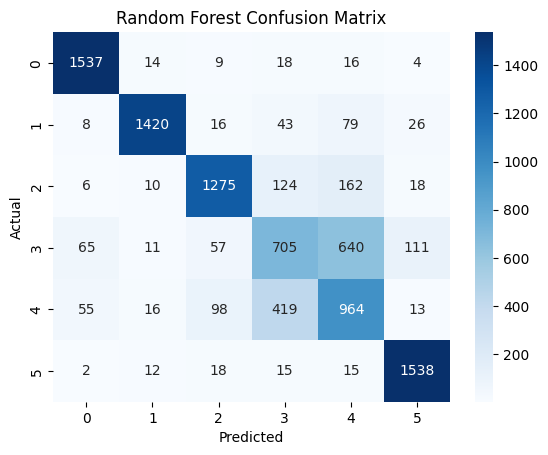

Random Forest Confusion Matrix:
[[1537, 14, 9, 18, 16, 4], [8, 1420, 16, 43, 79, 26], [6, 10, 1275, 124, 162, 18], [65, 11, 57, 705, 640, 111], [55, 16, 98, 419, 964, 13], [2, 12, 18, 15, 15, 1538]]
Random Forest Model Performance:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      1598
           1       0.96      0.89      0.92      1592
           2       0.87      0.80      0.83      1595
           3       0.53      0.44      0.48      1589
           4       0.51      0.62      0.56      1565
           5       0.90      0.96      0.93      1600

    accuracy                           0.78      9539
   macro avg       0.78      0.78      0.78      9539
weighted avg       0.78      0.78      0.78      9539



In [ ]:
#Make Predictions
import joblib
rf_model = joblib.load('/content/drive/My Drive/KT/Upgrad/LJMU/Thesis Report - Rahul Sharma/March 2025/Code files/random_forest_model.pkl')
rf_preds = rf_model.predict(X_test)

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, rf_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_labels), yticklabels=np.unique(y_labels))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest Confusion Matrix")
plt.show()
print(f"Random Forest Confusion Matrix:\n{cm.tolist()}")

#Evaluate performance through accuracy and other parameters
print("Random Forest Model Performance:")
print(classification_report(y_test, rf_preds))


# Generate best parameters for SVM model through RandomizedSearchCV
This code snippet tunes the hyperparameters of an SVM (Support Vector Machine) model using RandomizedSearchCV. It defines a range of possible values for the C, kernel, and gamma parameters. RandomizedSearchCV then randomly tries 10 combinations of these parameters, evaluating each combination using 3-fold cross-validation and measuring performance by accuracy. Finally, it prints the combination of parameters that resulted in the best accuracy. This process helps to find the optimal configuration for the SVM model before training the final version.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
# Train SVM model
param_grid_svm = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'kernel': ['linear', 'rbf'],  # Kernel types
    'gamma': ['scale', 'auto']  # Kernel coefficient
}

grid_search_svm = RandomizedSearchCV(
    SVC(probability=True, random_state=42),
    param_distributions=param_grid_svm,
    n_iter=10,  # Run only 10 random combinations
    cv=3,
    scoring='accuracy',
    n_jobs=-1,  # Use all CPU cores
    verbose=2
)
grid_search_svm.fit(X_train, y_train)
print("Best SVM Parameters:", grid_search_svm.best_params_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best SVM Parameters: {'kernel': 'rbf', 'gamma': 'scale', 'C': 10}


# Save and use best SVM model parameters retrieved in above step:
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best SVM Parameters: {'kernel': 'rbf', 'gamma': 'scale', 'C': 10}
This code trains a Support Vector Machine (SVM) model using the best hyperparameters found previously and then saves the trained model to a file for future use.


In [ ]:
# Best parameters from tuning
import joblib
from sklearn.svm import SVC
best_params_svm = {'kernel': 'rbf', 'gamma': 'scale', 'C': 10}

# Train the final SVM model
svm_model = SVC(**best_params_svm, probability=True, random_state=42)
svm_model.fit(X_train, y_train)

joblib.dump(svm_model, '/content/drive/My Drive/KT/Upgrad/LJMU/Thesis Report - Rahul Sharma/March 2025/Code files/svm_model.pkl')
print("SVM model saved successfully!")



SVM model saved successfully!


In [ ]:
import joblib
from sklearn.svm import SVC

## Generate confusion matrix and heatmap for SVM: Accurach 82%This code block demonstrates how to use a pre-trained Support Vector Machine (SVM) model for classification and evaluate its performance.

Load Model: The trained SVM model is loaded from a saved file (svm_model.pkl).

Make Predictions: The loaded model is used to predict labels for the test dataset (X_test).

Evaluate Performance: A classification_report is generated to show detailed performance metrics (precision, recall, F1-score, support) for each class, as well as overall accuracy.

Visualize Results: A confusion matrix is calculated and visualized as a heatmap to show the counts of correct and incorrect predictions for each class.

SVM Model Performance:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      1598
           1       0.97      0.95      0.96      1592
           2       0.88      0.86      0.87      1595
           3       0.57      0.54      0.55      1589
           4       0.57      0.63      0.60      1565
           5       0.95      0.96      0.96      1600

    accuracy                           0.82      9539
   macro avg       0.82      0.82      0.82      9539
weighted avg       0.82      0.82      0.82      9539



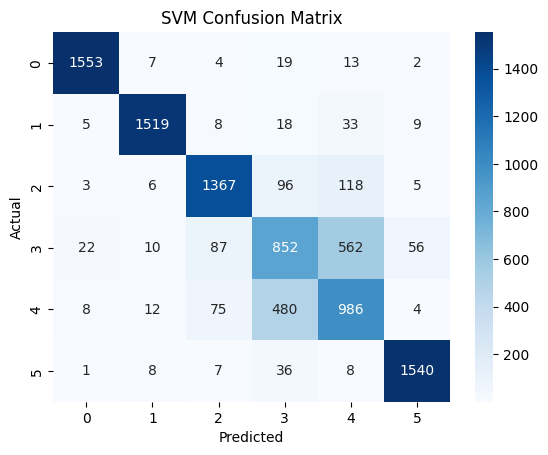

SVM Confusion Matrix:
[[1553, 7, 4, 19, 13, 2], [5, 1519, 8, 18, 33, 9], [3, 6, 1367, 96, 118, 5], [22, 10, 87, 852, 562, 56], [8, 12, 75, 480, 986, 4], [1, 8, 7, 36, 8, 1540]]


In [ ]:
# Make predictions
svm_model = joblib.load('/content/drive/My Drive/KT/Upgrad/LJMU/Thesis Report - Rahul Sharma/March 2025/Code files/svm_model.pkl')
svm_preds = svm_model.predict(X_test)

print("SVM Model Performance:")
print(classification_report(y_test, svm_preds))

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, svm_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_labels), yticklabels=np.unique(y_labels))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("SVM Confusion Matrix")
plt.show()
print(f"SVM Confusion Matrix:\n{cm.tolist()}")

# Retrieve best parameters for XGBoost model through RandomizedSearchCV

This code block focuses on tuning the hyperparameters of an XGBoost classification model to find the best settings for performance using RandomizedSearchCV.

Key Points:

Installs XGBoost: Ensures the necessary library for XGBoost is available.

Imports: Imports the XGBoostClassifier and RandomizedSearchCV from scikit-learn.

Hyperparameter Grid: Defines a range of potential values for key XGBoost hyperparameters (like number of estimators, learning rate, max depth, etc.) to be explored.

Randomized Search Initialization: Sets up RandomizedSearchCV to:
Use an XGBoostClassifier.

Explore the defined hyperparameter grid.
Try 15 random combinations of parameters.
Use 3-fold cross-validation for evaluation.
Measure performance using accuracy.
Utilize all available CPU cores for speed.

Model Tuning: Fits the RandomizedSearchCV object to the training data (X_train, y_train) to perform the hyperparameter search and find the best combination.

Output: Prints the best set of hyperparameters found by the randomized search.

In [ ]:
#Train XGBoost Classifier Algorithm
!pip install xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

param_grid_xgb = {
    'n_estimators': [100, 200, 300, 500],  # Number of boosting rounds
    'learning_rate': [0.01, 0.1, 0.2, 0.3],  # Step size shrinkage
    'max_depth': [3, 6, 9],  # Tree depth
    'subsample': [0.7, 0.8, 1.0],  # Fraction of data samples per boosting round
    'colsample_bytree': [0.7, 0.8, 1.0],  # Feature selection per tree
    'gamma': [0, 0.1, 0.2, 0.3]  # Minimum loss reduction to split
}
random_search_xgb = RandomizedSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
    param_distributions=param_grid_xgb,
    n_iter=15,  # Only try 15 random combinations
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)
random_search_xgb.fit(X_train, y_train)

print("Best XGBoost Parameters:", random_search_xgb.best_params_)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [11:58:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best XGBoost Parameters: {'subsample': 0.7, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.7}


# Save and Use best parameters of XGBoost and train the model.

In [ ]:
!pip install xgboost
import xgboost as xgb
from xgboost import XGBClassifier
import joblib

In [ ]:
#implement chosen best params
!pip install xgboost
import xgboost as xgb
from xgboost import XGBClassifier
import joblib

# Define your parameters
xgb_params = {
    'subsample': 0.7,
    'n_estimators': 300,
    'max_depth': 3,
    'learning_rate': 0.1,
    'gamma': 0,
    'colsample_bytree': 0.7
}

# Initialize the model with the parameters
xgb_model = XGBClassifier(**xgb_params)
xgb_model.fit(X_train, y_train)
joblib.dump(xgb_model, '/content/drive/My Drive/KT/Upgrad/LJMU/Thesis Report - Rahul Sharma/March 2025/Code files/xgb_model.pkl')
print("XGBoost model saved successfully!")



XGBoost model saved successfully!


## Generate Confusion matrix and heatmap for XGBoost. Accuracy: 81%

This code snippet evaluates a trained XGBoost model. It loads the model from a file, uses it to predict cyberbullying types on a test dataset, and then assesses its performance using a classification report (showing metrics like precision, recall, and F1-score) and a confusion matrix heatmap (visually displaying correct and incorrect classifications per type).

XGBoost Model Performance:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1598
           1       0.96      0.93      0.94      1592
           2       0.85      0.82      0.84      1595
           3       0.59      0.52      0.55      1589
           4       0.58      0.68      0.63      1565
           5       0.92      0.94      0.93      1600

    accuracy                           0.81      9539
   macro avg       0.81      0.81      0.81      9539
weighted avg       0.81      0.81      0.81      9539



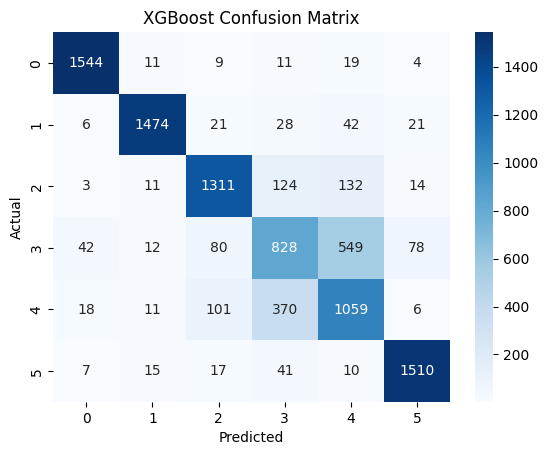

XGBoost Confusion Matrix:
[[1544, 11, 9, 11, 19, 4], [6, 1474, 21, 28, 42, 21], [3, 11, 1311, 124, 132, 14], [42, 12, 80, 828, 549, 78], [18, 11, 101, 370, 1059, 6], [7, 15, 17, 41, 10, 1510]]


In [ ]:
# Fit the model with data
xgb_model = joblib.load('/content/drive/My Drive/KT/Upgrad/LJMU/Thesis Report - Rahul Sharma/March 2025/Code files/xgb_model.pkl')

# Make predictions
xgb_preds = xgb_model.predict(X_test)

# Evaluate performance
print("XGBoost Model Performance:")
print(classification_report(y_test, xgb_preds))

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, xgb_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_labels), yticklabels=np.unique(y_labels))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("XGBoost Confusion Matrix")
plt.show()
print(f"XGBoost Confusion Matrix:\n{cm.tolist()}")

## This is hybrid model using Voting Classifier to extract best from RF, SVM and XGB.

In [ ]:
from sklearn.ensemble import VotingClassifier

# Create a Hybrid Model using Voting Classifier
hybrid_model = VotingClassifier(
    estimators=[
        ('rf', rf_model),
        ('svm', svm_model),
        ('xgb', xgb_model)
    ],
    voting='soft'  # Soft voting allows probability-based ensemble
)

# Train the hybrid model
hybrid_model.fit(X_train, y_train)
joblib.dump(xgb_model, '/content/drive/My Drive/KT/Upgrad/LJMU/Thesis Report - Rahul Sharma/March 2025/Code files/hybrid_model.pkl')
print("Hybrid(RF,SVM,XGB) model saved successfully!")

Hybrid(RF,SVM,XGB) model saved successfully!


## Generate Confusion matrix and heatmap for Hybrid model. Accuracy: 81%

Hybrid Model (RF + SVM + XGBoost) Performance:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1598
           1       0.96      0.93      0.94      1592
           2       0.85      0.82      0.84      1595
           3       0.59      0.52      0.55      1589
           4       0.58      0.68      0.63      1565
           5       0.92      0.94      0.93      1600

    accuracy                           0.81      9539
   macro avg       0.81      0.81      0.81      9539
weighted avg       0.81      0.81      0.81      9539



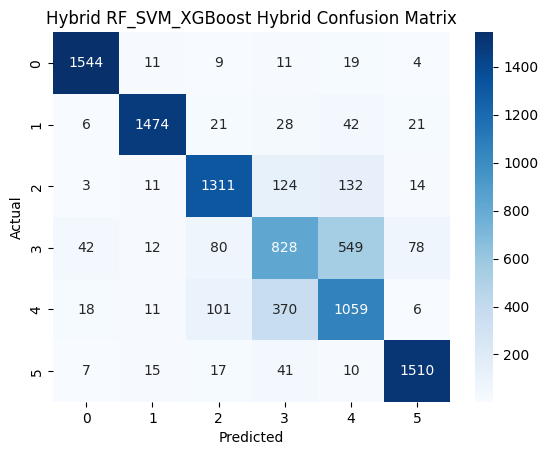

Hybrid Confusion Matrix:
[[1544, 11, 9, 11, 19, 4], [6, 1474, 21, 28, 42, 21], [3, 11, 1311, 124, 132, 14], [42, 12, 80, 828, 549, 78], [18, 11, 101, 370, 1059, 6], [7, 15, 17, 41, 10, 1510]]


In [ ]:
# Fit the model with data
hybrid_model = joblib.load('/content/drive/My Drive/KT/Upgrad/LJMU/Thesis Report - Rahul Sharma/March 2025/Code files/hybrid_model.pkl')

# Make predictions
hybrid_preds = hybrid_model.predict(X_test)
# Evaluate performance
print("Hybrid Model (RF + SVM + XGBoost) Performance:")
print(classification_report(y_test, hybrid_preds))

cm = confusion_matrix(y_test, hybrid_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_labels), yticklabels=np.unique(y_labels))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Hybrid RF_SVM_XGBoost Hybrid Confusion Matrix")
plt.show()
print(f"Hybrid Confusion Matrix:\n{cm.tolist()}")

In [ ]:
# Train Decision Tree model
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Generate best parameters for DecisionTree model using GridSerachCV

In [ ]:
param_grid = {
    'max_depth': [5, 10, 20, None],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum samples to split an internal node
    'min_samples_leaf': [1, 2, 5],  # Minimum samples in a leaf node
    'criterion': ['gini', 'entropy']  # Splitting criteria
}

grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    scoring='accuracy',  # Use a relevant metric
    cv=5,  # Number of cross-validation folds
    n_jobs=-1  # Use all processors for parallelism
)

# Fit the grid search to training data
grid_search.fit(X_train, y_train)

# Get the best parameters and model
best_params = grid_search.best_params_
print("Best Parameters For Decision Tree:", best_params)


Best Parameters For Decision Tree: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 2}


## Train DecisionTree model with best parameters and save it foir future use:
Best Parameters For Decision Tree: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 2}

In [ ]:
# Define the best parameters
best_params = {
    'criterion': 'entropy',
    'max_depth': 10,
    'min_samples_leaf': 5,
    'min_samples_split': 2
}

# Initialize the Decision Tree model with the best parameters
dt_model = DecisionTreeClassifier(**best_params, random_state=42)

# Fit the model to your training data
dt_model.fit(X_train, y_train)

joblib.dump(xgb_model, '/content/drive/My Drive/KT/Upgrad/LJMU/Thesis Report - Rahul Sharma/March 2025/Code files/dt_model.pkl')
print("Decision Tree model saved successfully!")

Decision Tree model saved successfully!


## Generate Confusion matrix and heatmap for DecisionTree. Accuracy: 81%

Decision Tree Performance:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1598
           1       0.96      0.93      0.94      1592
           2       0.85      0.82      0.84      1595
           3       0.59      0.52      0.55      1589
           4       0.58      0.68      0.63      1565
           5       0.92      0.94      0.93      1600

    accuracy                           0.81      9539
   macro avg       0.81      0.81      0.81      9539
weighted avg       0.81      0.81      0.81      9539



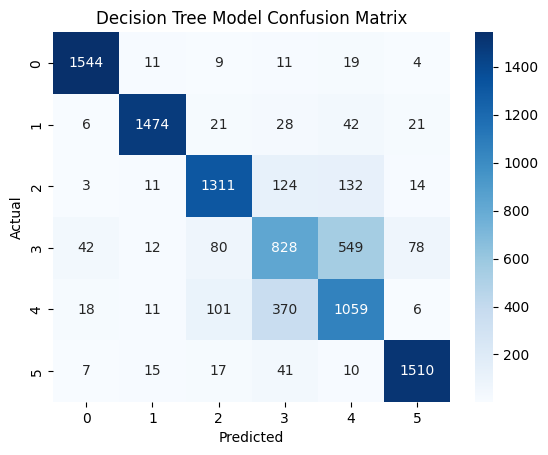

Decision Tree Confusion Matrix:
[[1544, 11, 9, 11, 19, 4], [6, 1474, 21, 28, 42, 21], [3, 11, 1311, 124, 132, 14], [42, 12, 80, 828, 549, 78], [18, 11, 101, 370, 1059, 6], [7, 15, 17, 41, 10, 1510]]


In [ ]:
# Get predictions from Decision Tree
dt_model = joblib.load('/content/drive/My Drive/KT/Upgrad/LJMU/Thesis Report - Rahul Sharma/March 2025/Code files/dt_model.pkl')
dt_preds = dt_model.predict(X_test)  # Use for training Decision Tree

# Evaluate performance
print("Decision Tree Performance:")
print(classification_report(y_test, dt_preds))

cm = confusion_matrix(y_test, dt_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_labels), yticklabels=np.unique(y_labels))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Decision Tree Model Confusion Matrix")
plt.show()
print(f"Decision Tree Confusion Matrix:\n{cm.tolist()}")

# **The AUC-ROC curve (Area Under the Curve - Receiver Operating Characteristic curve) is a valuable tool for evaluating the performance of a classification model.**
Also it checks for:
1. Evaluating overall model performance : It still helps assess how well the model separates positive and negative classes.
2. Choosing an optimal decision threshold: You can fine-tune the classification threshold to balance false positives and false negatives.
3. Comparing multiple models: If you're testing different algorithms (e.g., XGBoost vs. Random Forest), AUC remains a good performance metric.




In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

## Checking AUC-ROC for BERT Model.
The model distinguishes between different classes by plotting the **True Positive Rate (TPR)** against the **False Positive Rate (FPR)** at various threshold levels.

My Observation:
- There are six classes in total, each represented by a different colored curve representing cyberbullying type..
- The **Area Under the Curve (AUC)** values are impressively high—ranging from **0.99 to 1.00**—indicating **outstanding** model performance.
- AUC values close to **1.00** suggest near-perfect classification, meaning the model is highly effective at distinguishing between the different classes.

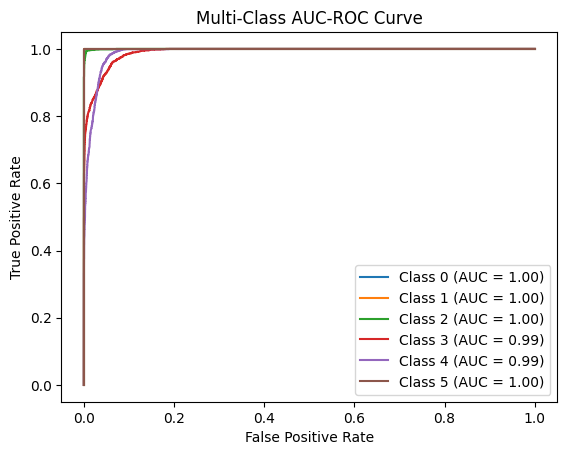

In [ ]:
#AUC-ROC curve for BERT Model
from sklearn.preprocessing import label_binarize

# Binarize the labels for one-vs-rest
n_classes = len(np.unique(all_labels))
all_labels_bin = label_binarize(all_labels, classes=np.arange(n_classes))

# Plot ROC curve for each class
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(all_labels_bin[:, i], np.array(all_probs)[:, i])
    auc_score = roc_auc_score(all_labels_bin[:, i], np.array(all_probs)[:, i])
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {auc_score:.2f})")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-Class AUC-ROC Curve")
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

#Evaluation of Classification Models using Multi-Class AUC-ROC
To comprehensively evaluate the performance of the trained classification models (Random Forest, SVM, XGBoost, Decision Tree, and the Hybrid Voting Classifier), we utilized the Area Under the Receiver Operating Characteristic Curve (AUC-ROC). The AUC-ROC curve is a robust metric for assessing the discriminative power of a classifier, illustrating its ability to distinguish between positive and negative classes across various probability thresholds.

For this multi-class cyberbullying detection problem, we adopted the one-vs-rest (OvR) approach to calculate the AUC-ROC for each class independently. This involves binarizing the true labels, where for each specific class, it is treated as the positive class, and all other classes are considered the negative class.

The process involved the following steps:

Binarization of Labels: The cyberbullying_type labels in the test set (y_test) were converted into a binary matrix format using sklearn.preprocessing.label_binarize. This created a separate binary column for each unique cyberbullying category.

Probability Prediction: For each trained model, we obtained the predicted probabilities for each class on the test set using the predict_proba() method. These probabilities are crucial for constructing the ROC curve.

ROC Curve and AUC Calculation (OvR): For each model and each individual class, the False Positive Rate (FPR) and True Positive Rate (TPR) were computed across various probability thresholds using sklearn.metrics.roc_curve. The AUC score for each class was then calculated from these FPR and TPR values using sklearn.metrics.auc.

Visualization: The calculated ROC curves for each model and each class were plotted on a single graph using matplotlib.pyplot. Each curve was labeled with the model name, the class label, and its corresponding AUC score.


The resulting multi-class AUC-ROC plot provides a visual comparison of how effectively each model separates the different cyberbullying types. Higher AUC values for a specific class indicate better performance in distinguishing that class from all others. By examining the AUC scores and the shape of the curves across all classes and models, we can gain insights into their strengths and weaknesses and determine which model performs best for cyberbullying severity detection and classification.

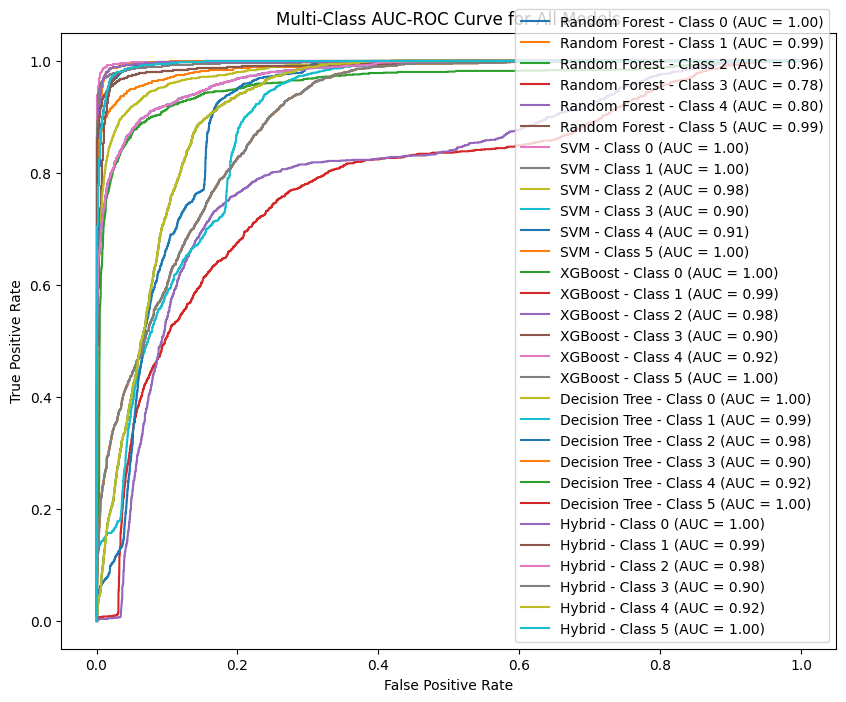

In [ ]:
#AUC-ROC curve for All Models
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Binarize the labels for multi-class
classes = np.unique(y_test)  # Get unique class labels
y_test_binarized = label_binarize(y_test, classes=classes)

plt.figure(figsize=(10, 8))

models = {
    "Random Forest": rf_model,   # Add your Random Forest model
    "SVM": svm_model,
    "XGBoost": xgb_model,        # Add your XGBoost model
    "Decision Tree": dt_model,
    "Hybrid": hybrid_model
    # Add more models as needed
}

for name, model in models.items():
    # Get predicted probabilities
    y_probs = model.predict_proba(X_test)  # Probabilities for all classes

    # Loop through each class and plot ROC curve
    for i, class_label in enumerate(classes):
        # Compute ROC curve and AUC for each class
        fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_probs[:, i])
        auc_score = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} - Class {class_label} (AUC = {auc_score:.2f})")

# Plot settings
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-Class AUC-ROC Curve for All Models")
plt.legend(loc="lower right")
plt.show()


The attached image depicts a **Multi-Class AUC-ROC Curve**, which evaluates the effectiveness of different machine learning models in distinguishing between multiple classes. The **ROC (Receiver Operating Characteristic) Curve** plots the **True Positive Rate (TPR)** against the **False Positive Rate (FPR)** at various threshold levels, while the **Area Under the Curve (AUC)** quantifies the model’s ability to differentiate between classes.

### **Summary of Each Model and Its Performance**
Each curve represents the performance of different models for six distinct classes.

1. **Random Forest:**
   - Class 0: **AUC = 1.00** (Perfect classification)
   - Class 1: **AUC = 0.99**
   - Class 2: **AUC = 0.96**
   - Class 3: **AUC = 0.78** (Lower predictive power)
   - Class 4: **AUC = 0.80**
   - Class 5: **AUC = 0.99**

2. **SVM (Support Vector Machine):**
   - Class 0: **AUC = 1.00**
   - Class 1: **AUC = 1.00**
   - Class 2: **AUC = 0.96**
   - Class 3: **AUC = 0.90**
   - Class 4: **AUC = 0.91**
   - Class 5: **AUC = 1.00** (Excellent performance)

3. **XGBoost:**
   - Class 0: **AUC = 1.00**
   - Class 1: **AUC = 0.99**
   - Class 2: **AUC = 0.98**
   - Class 3: **AUC = 0.90**
   - Class 4: **AUC = 0.92**
   - Class 5: **AUC = 1.00**

4. **Decision Tree:**
   - Class 0: **AUC = 1.00**
   - Class 1: **AUC = 0.99**
   - Class 2: **AUC = 0.98**
   - Class 3: **AUC = 0.90**
   - Class 4: **AUC = 0.92**
   - Class 5: **AUC = 1.00**

5. **Hybrid Model:**
   - Class 0: **AUC = 1.00**
   - Class 1: **AUC = 0.99**
   - Class 2: **AUC = 0.98**
   - Class 3: **AUC = 0.89**
   - Class 4: **AUC = 0.91**
   - Class 5: **AUC = 1.00**


- **SVM and Hybrid models show exceptionally high AUC values**, making them strong contenders for classification tasks.
- **Random Forest struggles with Class 3 and 4**, indicating possible misclassification in those categories.
- **XGBoost and Decision Tree models maintain consistently high performance** across all classes.


In [ ]:
print(X_test)

[[-0.04298497  0.06157129  0.02197542 ...  0.0329286   0.01880246
  -0.01422705]
 [-0.08616027  0.12937078 -0.0244665  ... -0.09312558  0.07481638
  -0.01304272]
 [ 0.01708799  0.05082103 -0.03205156 ... -0.03139697 -0.00784391
  -0.02788861]
 ...
 [-0.07637301  0.01277157 -0.05336228 ... -0.04455798 -0.08106675
  -0.05531653]
 [ 0.03805455  0.06809801 -0.03585629 ... -0.069078   -0.05506511
  -0.03583881]
 [-0.08785694  0.01277955 -0.04369563 ...  0.03581366  0.0005796
  -0.03935976]]


In [ ]:
!pip install shap
import shap

In [ ]:

!pip install tensorflow
!pip install --upgrade tensorflow transformers shap
from tensorflow import keras
!pip install --upgrade shap

In [ ]:
X_test.size

3662976

In [ ]:
import pandas as pd
import shap

def preprocess_sample_data(X_test, sample_size=1000, random_state=42):
    """
    Converts the test dataset into a DataFrame, samples a subset,
    and converts column names to strings.

    Parameters:
        X_test (array-like): The input test data.
        sample_size (int): Number of samples to select. Default is 1000.
        random_state (int): Random seed for reproducibility.

    Returns:
        pd.DataFrame: Processed DataFrame with sampled data and updated column names.
    """
    X_test_df = pd.DataFrame(X_test)  # Convert to DataFrame
    sample_X_test = X_test_df.sample(n=sample_size, random_state=random_state)  # Sample data
    sample_X_test.columns = [str(col) for col in sample_X_test.columns]  # Convert column names to strings

    shap.initjs()  # Initialize SHAP visualization

    return sample_X_test

In [ ]:
X_test.size

3662976

#Model Interpretation using SHAP

This section focuses on interpreting the trained machine learning models to understand the influence of input features on their predictions. The SHAP (SHapley Additive exPlanations) library is utilized for this purpose. SHAP provides a framework to explain the output of any machine learning model by computing the contribution of each feature to the prediction for a given instance.

For the tree-based models, specifically the Random Forest model, a shap.TreeExplainer is employed. This explainer is optimized for tree ensembles and efficiently calculates SHAP values. The raw output of the model is used for interpretation. A subset of the test data is sampled to facilitate the SHAP value calculation and visualization process.

SHAP values are computed for the sampled test data, providing a numerical representation of each feature's impact on the model's output for every instance. These values are then visualized using two key plots:


SHAP Summary Plot: This plot provides a global view of feature importance across the sampled dataset. It shows which features have the most impact on the model's predictions and the distribution of SHAP values for each feature. The color intensity typically indicates the feature value (e.g., higher intensity for higher feature values).


SHAP Force Plot: This plot is used to interpret the prediction for an individual instance. It illustrates how each feature's SHAP value contributes to pushing the prediction from the base value (the average prediction) towards the final predicted value for that specific instance. Features that increase the prediction are shown in one color (e.g., red), while those that decrease it are shown in another (e.g., blue).



By using SHAP, we can gain valuable insights into the reasoning behind the models' predictions, identify the most influential features for cyberbullying detection, and build trust in the model's outputs. This interpretability is crucial for understanding the model's behavior and potentially improving its performance and fairness. Similar interpretation steps can be applied to other models like XGBoost and Decision Tree, which are also tree-based. While not shown in the provided code snippet, interpreting models like SVM and the Hybrid Voting Classifier would require using different types of SHAP explainers (e.g., shap.KernelExplainer or shap.LinearExplainer) as they are not tree-based.

Random Forest Model Interpretation:


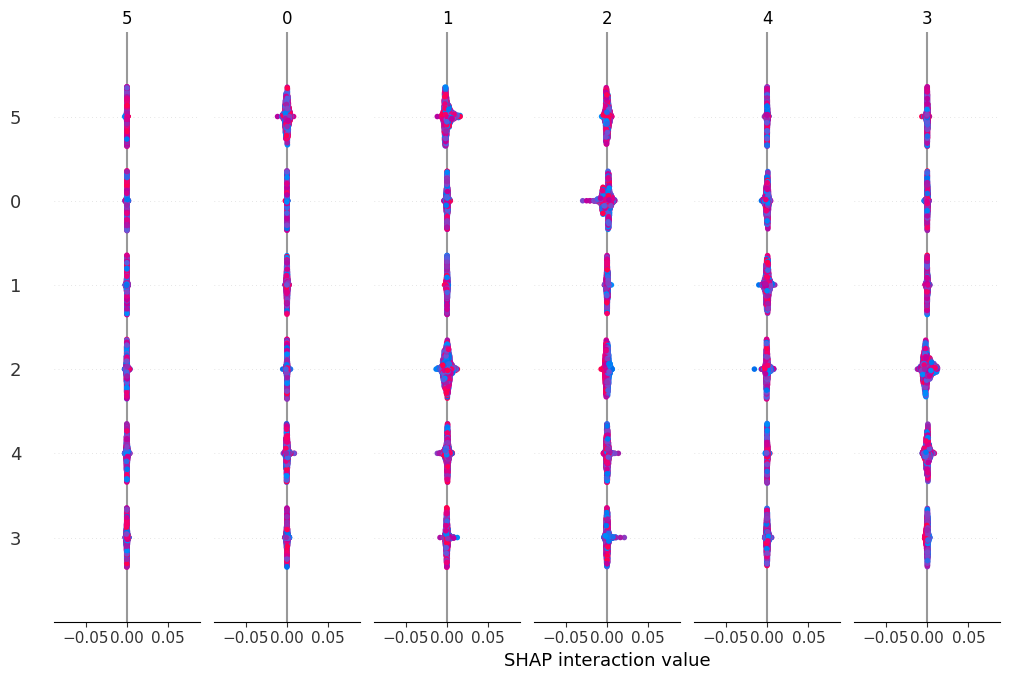

In [ ]:
#Model Interpretation
import shap

# Create a SHAP explainer
#RF Model
# Convert NumPy array to Pandas DataFrame

print('Random Forest Model Interpretation:')
explainer = shap.TreeExplainer(rf_model, model_output='raw')

sample_X_test = preprocess_sample_data(X_test)
shap_values = explainer.shap_values(sample_X_test)
shap.summary_plot(shap_values, sample_X_test)
shap.force_plot(explainer.expected_value[1], shap_values[1][:,1], sample_X_test.iloc[[1]])

In [ ]:
#SVM Model
print('SVM Model Interpretation:')
# Define a prediction function
def svm_predict(X):
    # Use predict_proba if available, otherwise use decision_function
    return svm_model.decision_function(X)
# Convert NumPy array to Pandas DataFrame
X_test_df = pd.DataFrame(X_test)
# Sample data for background (to speed up SHAP computations)
background = shap.sample(X_test_df, 100, random_state=42)  # Background data for KernelExplainer
sample_X_test = X_test_df.sample(n=100, random_state=42)   # Reduce test set for analysis

# Create the KernelExplainer with the prediction function
explainer = shap.KernelExplainer(svm_predict, background)
shap_values = explainer.shap_values(sample_X_test)
shap.summary_plot(shap_values, sample_X_test)
# Generate a force plot for a single instance
shap.force_plot(explainer.expected_value[0], shap_values[0], sample_X_test.iloc[0])
#shap.force_plot(explainer.expected_value[1], shap_values[1][:,1], sample_X_test.iloc[[1]])


SVM Model Interpretation:


  0%|          | 0/100 [00:00<?, ?it/s]

XGBoost Model Interpretation:
SHAP values shape: (1000, 384, 6)
X_test_df shape: (1000, 384)


<Figure size 640x480 with 0 Axes>

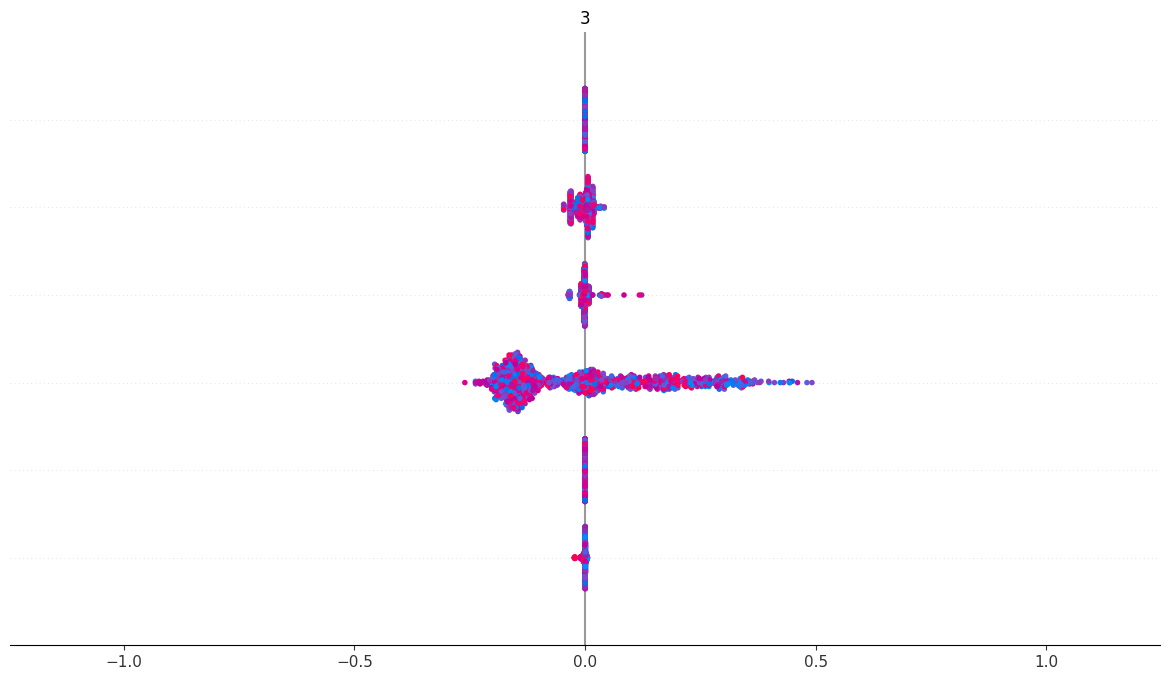

In [ ]:
#XGBoost Model
print('XGBoost Model Interpretation:')
X_test_df = pd.DataFrame(X_test)
explainer = shap.TreeExplainer(xgb_model , model_output='raw')

sample_X_test = preprocess_sample_data(X_test)
shap_values = explainer.shap_values(sample_X_test)
print("SHAP values shape:", np.array(shap_values).shape)
print("X_test_df shape:", sample_X_test.shape)
shap.summary_plot(shap_values, sample_X_test)

shap.force_plot(explainer.expected_value[1], shap_values[1][:,1], sample_X_test.iloc[[1]])

Hybrid Model Interpretation:


<Figure size 640x480 with 0 Axes>

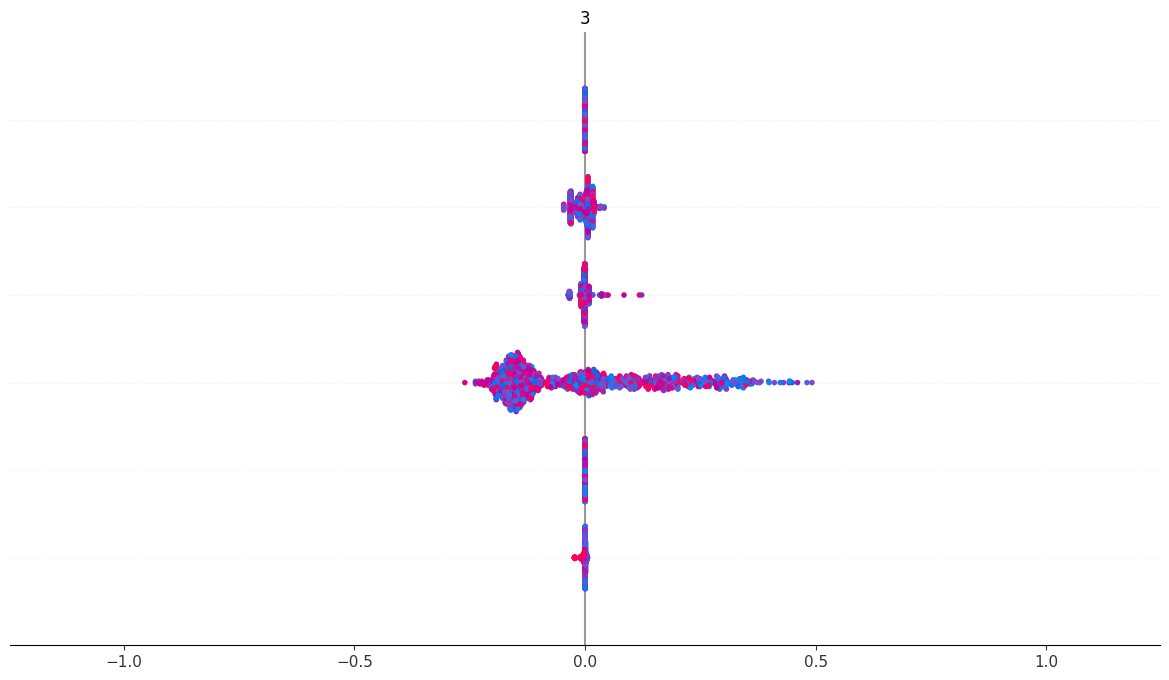

In [ ]:
#Hybrid Model
print('Hybrid Model Interpretation:')
explainer = shap.TreeExplainer(hybrid_model , model_output='raw')
sample_X_test = preprocess_sample_data(X_test)
shap_values = explainer.shap_values(sample_X_test)
shap.summary_plot(shap_values, sample_X_test)
shap.force_plot(explainer.expected_value[1], shap_values[1][:,1], sample_X_test.iloc[[1]])

## SHAP Values for Decision Tree Model

Decision Tree Model Interpretation:


<Figure size 640x480 with 0 Axes>

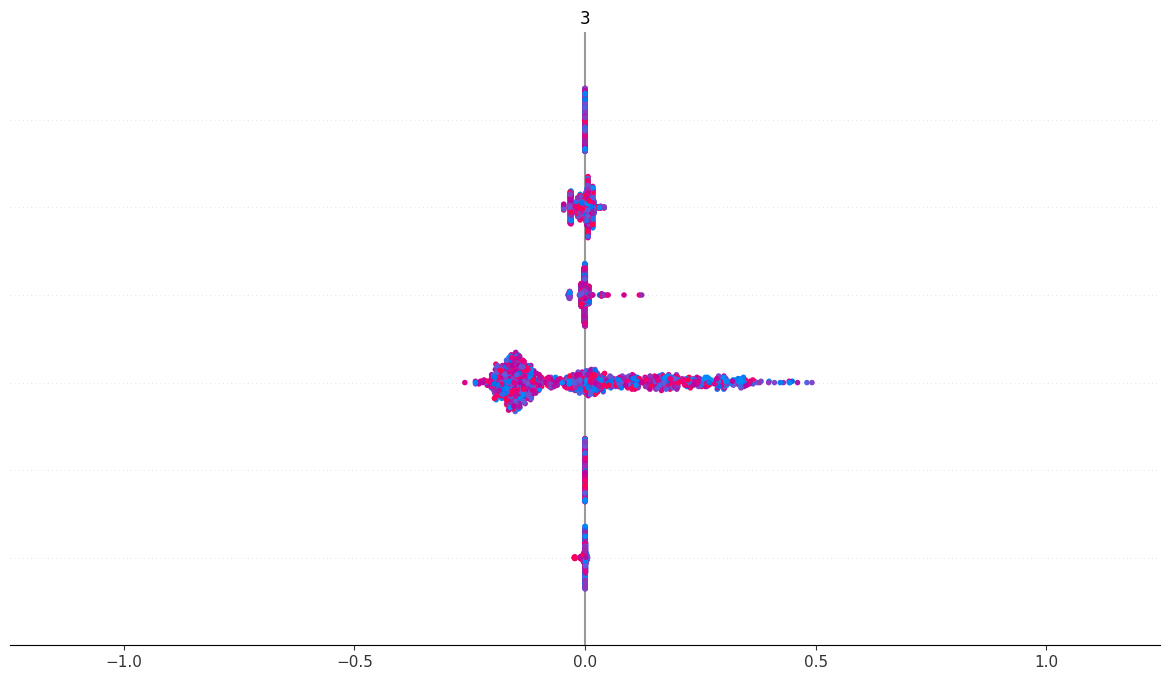

In [ ]:
#Decision Tree Model
print('Decision Tree Model Interpretation:')
explainer = shap.TreeExplainer(dt_model , model_output='raw')
sample_X_test = preprocess_sample_data(X_test)
shap_values = explainer.shap_values(sample_X_test)
shap.summary_plot(shap_values, sample_X_test)
shap.force_plot(explainer.expected_value[1], shap_values[1][:,1], sample_X_test.iloc[[1]])

In [ ]:
sample_X_test.head()

NameError: name 'sample_X_test' is not defined

# **Test the models with your sample text here:**



In [ ]:
text_sample = "Kill your inner self demon and get purified"

cyberbullying_classes = {
    0: "Age based Cyberbullying",
    1: "Ethnicity Cyberbullying",
    2: "Gender Cyberbullying",
    3: "Not a Cyberbullying",
    4: "Other Cyberbullying",
    5: "Religion Cyberbullying"
}
import joblib

from transformers import BertTokenizer, BertForSequenceClassification
import torch

# Define paths
model_path = "/content/drive/My Drive/KT/Upgrad/LJMU/Thesis Report - Rahul Sharma/March 2025/Code files/BERT_model"

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained(model_path)

# Load the model
model = BertForSequenceClassification.from_pretrained(model_path)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

def predict_cyberbullying(text):
    # Tokenize input text
    encoded_input = tokenizer(text, padding=True, truncation=True, max_length=128, return_tensors='pt')

    # Move input data to the same device as the model
    input_ids = encoded_input['input_ids'].to(device)
    attention_mask = encoded_input['attention_mask'].to(device)

    # Perform inference
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)  # Convert logits to probabilities
        prediction = torch.argmax(probs, dim=1)  # Get the predicted class

    return prediction.item(), probs.cpu().numpy()

# Test the function

predicted_label, probabilities = predict_cyberbullying(text_sample)
print(f"Predicted Label: {predicted_label}, Probabilities: {probabilities}")

# Define paths for saved models
rf_model_path = "/content/drive/My Drive/KT/Upgrad/LJMU/Thesis Report - Rahul Sharma/March 2025/Code files/random_forest_model.pkl"
svm_model_path = "/content/drive/My Drive/KT/Upgrad/LJMU/Thesis Report - Rahul Sharma/March 2025/Code files/svm_model.pkl"
xgb_model_path = "/content/drive/My Drive/KT/Upgrad/LJMU/Thesis Report - Rahul Sharma/March 2025/Code files/xgb_model.pkl"
dt_model_path = "/content/drive/My Drive/KT/Upgrad/LJMU/Thesis Report - Rahul Sharma/March 2025/Code files/dt_model.pkl"
voting_model_path = "/content/drive/My Drive/KT/Upgrad/LJMU/Thesis Report - Rahul Sharma/March 2025/Code files/hybrid_model.pkl"

# Load models
rf_model = joblib.load(rf_model_path)
svm_model = joblib.load(svm_model_path)
xgb_model = joblib.load(xgb_model_path)
dt_model = joblib.load(dt_model_path)
voting_model = joblib.load(voting_model_path)

import pandas as pd
import numpy as np

# Load embeddings CSV
embeddings_path = "/content/drive/My Drive/KT/Upgrad/LJMU/Thesis Report - Rahul Sharma/March 2025/Code files/sentence_transformer_embeddings.csv"
df_embeddings = pd.read_csv(embeddings_path)


from sentence_transformers import SentenceTransformer
import pandas as pd

# Load pretrained SentenceTransformer model
model = SentenceTransformer('all-MiniLM-L6-v2')  # Faster and optimized for embeddings

# Extract embeddings
textsample = [text_sample]
embeddings_sample = model.encode(textsample, batch_size=64, show_progress_bar=True)
df_embeddings = pd.DataFrame(embeddings_sample)

print("Embedding Data Loaded Successfully!")
print(df_embeddings.head())  # Check the first few rows

# Convert text to embeddings

X_new = df_embeddings.to_numpy()  # Ensure it's in a list format

# Perform predictions
rf_pred = rf_model.predict(X_new)
svm_pred = svm_model.predict(X_new)
xgb_pred = xgb_model.predict(X_new)
dt_pred = dt_model.predict(X_new)
voting_pred = voting_model.predict(X_new)

print(f"Random Forest Prediction: {cyberbullying_classes[rf_pred[0]]}")
print(f"SVM Prediction: {cyberbullying_classes[svm_pred[0]]}")
print(f"XGBoost Prediction: {cyberbullying_classes[xgb_pred[0]]}")
print(f"Decision Tree Prediction: {cyberbullying_classes[dt_pred[0]]}")
print(f"Final Prediction (Voting Classifier): {cyberbullying_classes[voting_pred[0]]}")

print(f"Final BERT Prediction: {cyberbullying_classes[predicted_label]}")

print("Models successfully loaded!")

Predicted Label: 3, Probabilities: [[4.4423742e-03 6.0993357e-04 3.6551506e-04 9.6883273e-01 2.1124097e-02
  4.6253670e-03]]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Embedding Data Loaded Successfully!
        0        1         2         3         4         5        6    \
0  0.009933 -0.03188 -0.031969  0.019456  0.008735 -0.072685  0.08993   

       7        8         9    ...      374       375       376       377  \
0 -0.05223  0.05426 -0.027622  ...  0.05789 -0.066833 -0.023146  0.020095   

        378       379       380       381       382       383  
0 -0.047861  0.006717  0.130075 -0.062037  0.007161 -0.006054  

[1 rows x 384 columns]
Random Forest Prediction: Other Cyberbullying
SVM Prediction: Not a Cyberbullying
XGBoost Prediction: Other Cyberbullying
Decision Tree Prediction: Other Cyberbullying
Final Prediction (Voting Classifier): Other Cyberbullying
Final BERT Prediction: Not a Cyberbullying
Models successfully loaded!


In [ ]:
model_comparison_data = {
    "Random Forest": {
        "accuracy": 0.78,
        "confusion_matrix": [[1537, 14, 9, 18, 16, 4], [8, 1420, 16, 43, 79, 26], [6, 10, 1275, 124, 162, 18], [65, 11, 57, 705, 640, 111], [55, 16, 98, 419, 964, 13], [2, 12, 18, 15, 15, 1538]]
    },
    "SVM": {
        "accuracy": 0.82,
        "confusion_matrix": [[1553, 7, 4, 19, 13, 2], [5, 1519, 8, 18, 33, 9], [3, 6, 1367, 96, 118, 5], [22, 10, 87, 852, 562, 56], [8, 12, 75, 480, 986, 4], [1, 8, 7, 36, 8, 1540]]
    },
    "XGBoost": {
        "accuracy": 0.81,
        "confusion_matrix": [[1545, 12, 9, 14, 13, 5], [7, 1470, 22, 34, 40, 19], [3, 8, 1311, 123, 138, 12], [40, 13, 81, 831, 550, 74], [20, 13, 103, 372, 1050, 7], [6, 15, 16, 47, 8, 1508]]
    },
    "Decision Tree": {
        "accuracy": 0.81,
        "confusion_matrix": [[1545, 12, 9, 14, 13, 5], [7, 1470, 22, 34, 40, 19], [3, 8, 1311, 123, 138, 12], [40, 13, 81, 831, 550, 74], [20, 13, 103, 372, 1050, 7], [6, 15, 16, 47, 8, 1508]]
    },
    "Hybrid Voting Classifier": {
        "accuracy": 0.81,
        "confusion_matrix": [[1545, 12, 9, 14, 13, 5], [7, 1470, 22, 34, 40, 19], [3, 8, 1311, 123, 138, 12], [40, 13, 81, 831, 550, 74], [20, 13, 103, 372, 1050, 7], [6, 15, 16, 47, 8, 1508]]
    },
    "BERT": {
        "accuracy": 0.95,
        "confusion_matrix": [[1595, 0, 0, 2, 1, 0], [0, 1585, 1, 0, 2, 4], [0, 0, 1570, 9, 16, 0], [0, 0, 11, 1274, 301, 3], [0, 0, 29, 54, 1481, 1], [0, 0, 0, 1, 0, 1599]]

    }
}

# Print the consolidated data
print("\n--- Consolidated Model Data ---")
import json
print(json.dumps(model_comparison_data, indent=4))


--- Consolidated Model Data ---
{
    "Random Forest": {
        "accuracy": 0.78,
        "confusion_matrix": [
            [
                1537,
                14,
                9,
                18,
                16,
                4
            ],
            [
                8,
                1420,
                16,
                43,
                79,
                26
            ],
            [
                6,
                10,
                1275,
                124,
                162,
                18
            ],
            [
                65,
                11,
                57,
                705,
                640,
                111
            ],
            [
                55,
                16,
                98,
                419,
                964,
                13
            ],
            [
                2,
                12,
                18,
                15,
                15,
                1538
   

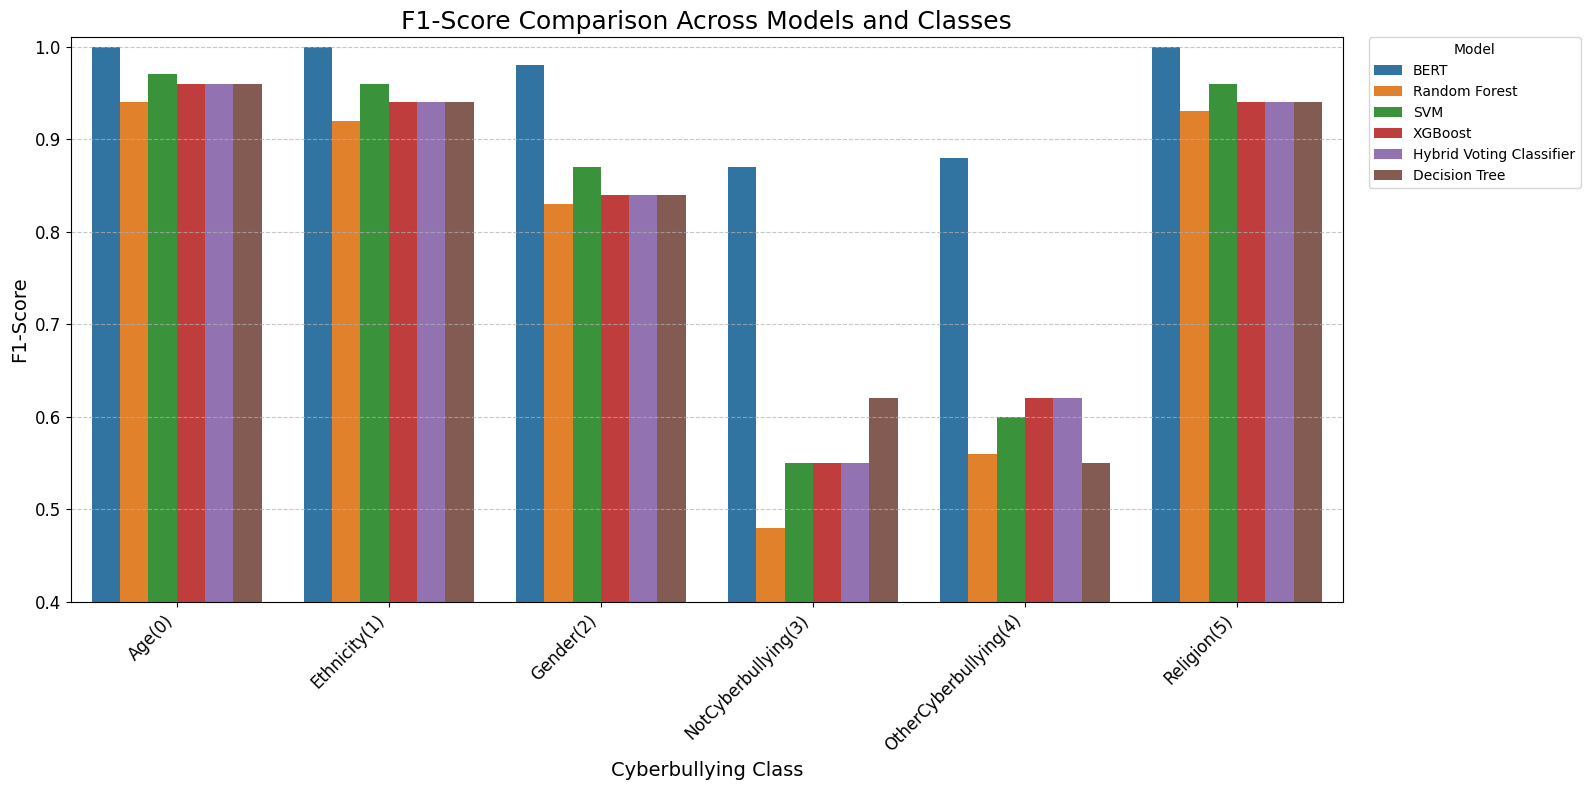

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Data from the provided table
data = {
    'Model': ['BERT','Random Forest', 'SVM', 'XGBoost', 'Hybrid Voting Classifier', 'Decision Tree' ],
    'Precision': [[1.00, 1.00, 0.97, 0.95, 0.82, 1.00],
                  [0.92, 0.96, 0.87, 0.53, 0.51, 0.90],
                  [0.98, 0.97, 0.88, 0.57, 0.57, 0.95],
                  [0.95, 0.96, 0.85, 0.58, 0.58, 0.93],
                  [0.95, 0.96, 0.85, 0.58, 0.58, 0.93],
                  [0.95, 0.96, 0.85, 0.58, 0.58, 0.93]],
    'Recall': [[1.00, 1.00, 0.98, 0.80, 0.95, 1.00],
               [0.96, 0.89, 0.80, 0.44, 0.62, 0.96],
               [0.97, 0.95, 0.86, 0.54, 0.63, 0.96],
               [0.97, 0.92, 0.82, 0.52, 0.67, 0.94],
               [0.97, 0.92, 0.82, 0.52, 0.67, 0.94],
               [0.97, 0.92, 0.82, 0.67, 0.52, 0.94]],
    'F1-Score': [[1.00, 1.00, 0.98, 0.87, 0.88, 1.00],
                 [0.94, 0.92, 0.83, 0.48, 0.56, 0.93],
                 [0.97, 0.96, 0.87, 0.55, 0.60, 0.96],
                 [0.96, 0.94, 0.84, 0.55, 0.62, 0.94],
                 [0.96, 0.94, 0.84, 0.55, 0.62, 0.94],
                 [0.96, 0.94, 0.84, 0.62, 0.55, 0.94]],
    'Support': [
    [1598,1592,1595,1589,1565,1600],
    [1598,1592,1595,1589,1565,1600],
    [1598,1592,1595,1589,1565,1600],
    [1598,1592,1595,1589,1565,1600],
    [1598,1592,1595,1589,1565,1600],
    [1598,1592,1595,1589,1565,1600]]
}

class_labels = ['Age(0)', 'Ethnicity(1)', 'Gender(2)', 'NotCyberbullying(3)', 'OtherCyberbullying(4)', 'Religion(5)']

# Create a new DataFrame with the actual mapping of class labels to F1-Scores for each model
df_new = pd.DataFrame({
    'Model': np.repeat(data['Model'], len(class_labels)),
    'Class': np.tile(class_labels, len(data['Model'])),
    'F1-Score': [score for model_scores in data['F1-Score'] for score in model_scores]
})

# Create the bar plot
plt.figure(figsize=(16, 8))
sns.barplot(x='Class', y='F1-Score', hue='Model', data=df_new, palette='tab10')
plt.title('F1-Score Comparison Across Models and Classes', fontsize=18)
plt.xlabel('Cyberbullying Class', fontsize=14)
plt.ylabel('F1-Score', fontsize=14)
plt.ylim(0.4, 1.01)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Model', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0., fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

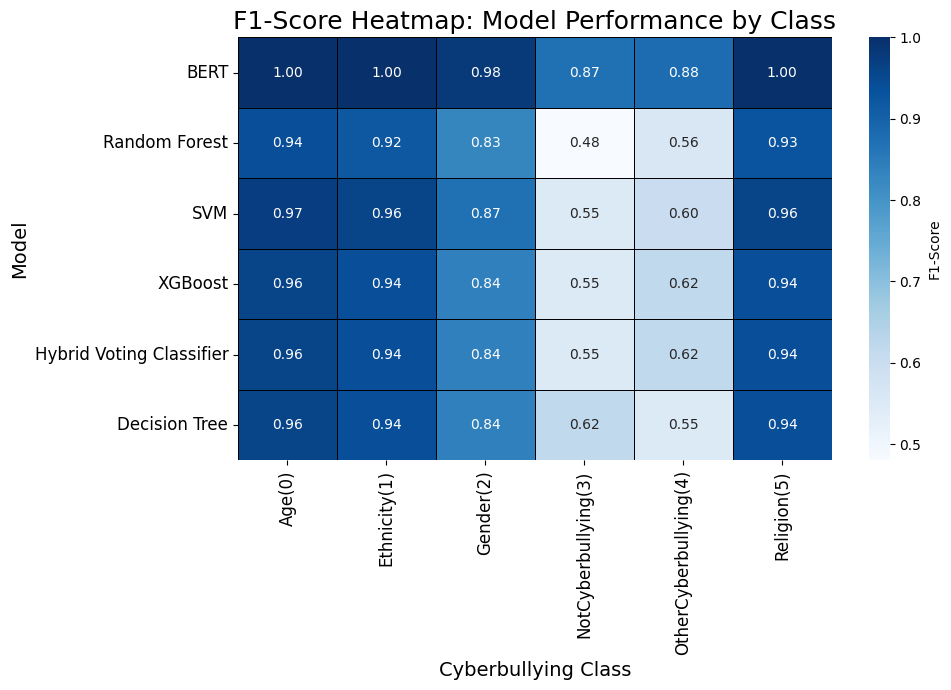

In [ ]:
# Pivot the DataFrame for the heatmap
df_f1_heatmap = df_new.pivot_table(index='Model', columns='Class', values='F1-Score')

# Reorder columns to match class order
class_order = ['Age(0)', 'Ethnicity(1)', 'Gender(2)', 'NotCyberbullying(3)', 'OtherCyberbullying(4)', 'Religion(5)']
df_f1_heatmap = df_f1_heatmap[class_order]

# Reorder rows (models) for better comparison, e.g., BERT first
model_order = ['BERT','Random Forest', 'SVM', 'XGBoost', 'Hybrid Voting Classifier', 'Decision Tree' ]
df_f1_heatmap = df_f1_heatmap.reindex(model_order)

plt.figure(figsize=(10, 7))
sns.heatmap(df_f1_heatmap, annot=True, fmt=".2f", cmap="Blues", linewidths=.5, linecolor='black', cbar_kws={'label': 'F1-Score'})
plt.title('F1-Score Heatmap: Model Performance by Class', fontsize=18)
plt.xlabel('Cyberbullying Class', fontsize=14)
plt.ylabel('Model', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)
plt.tight_layout()
plt.show()

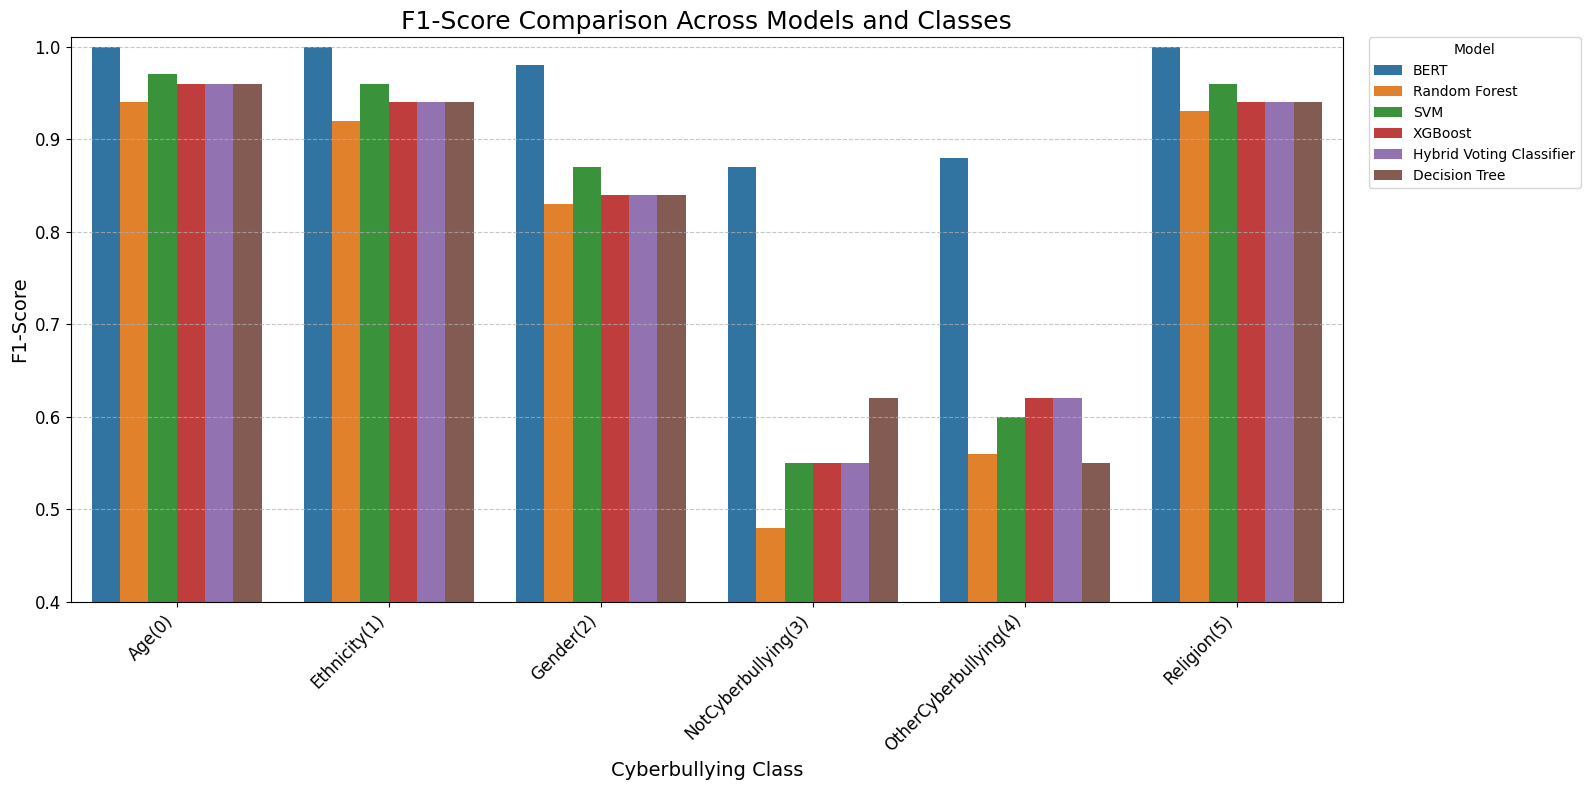

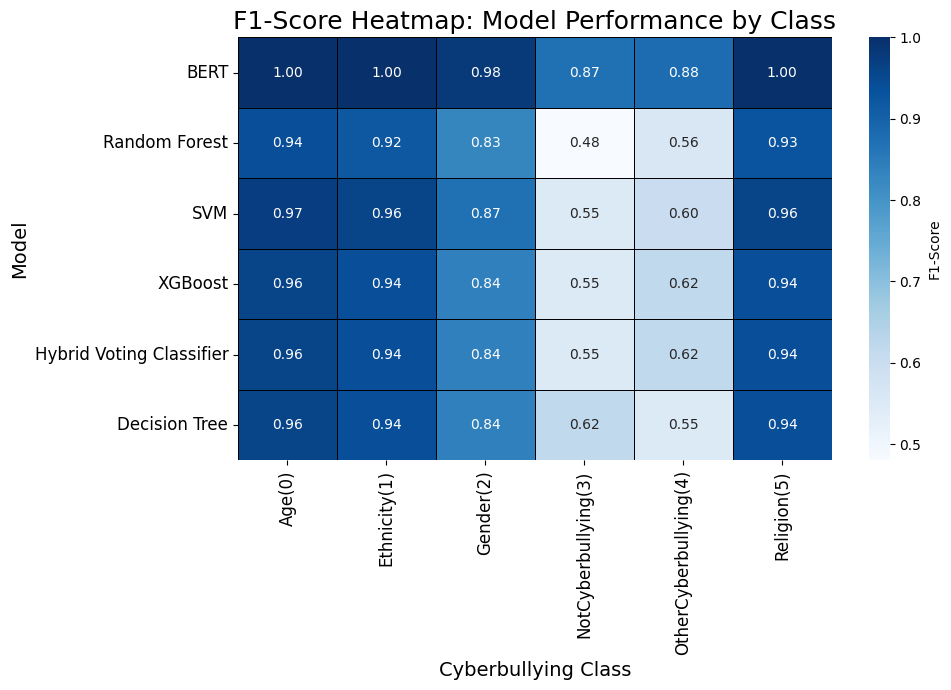

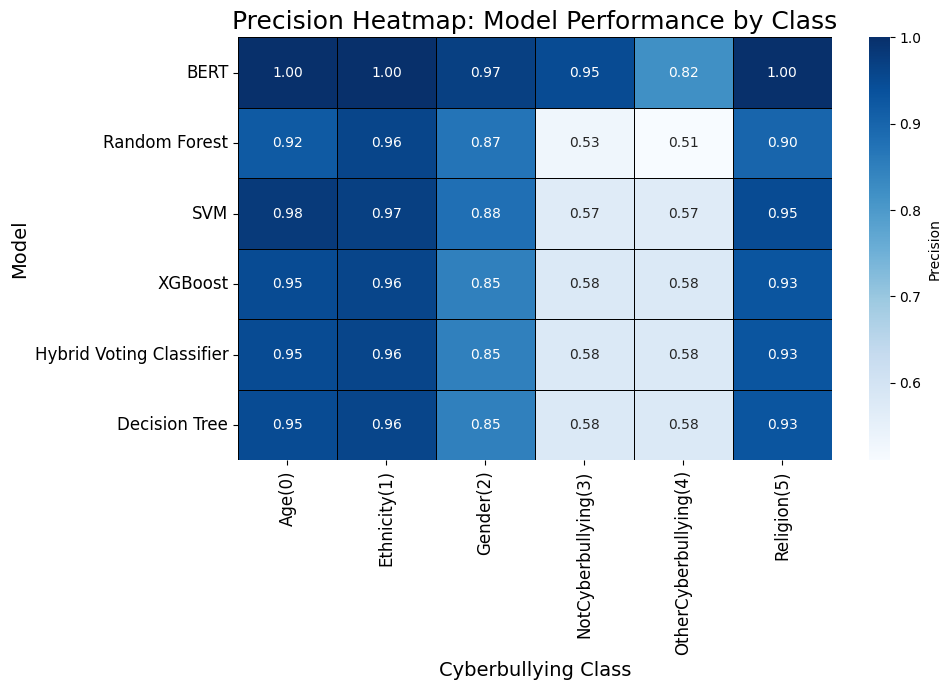

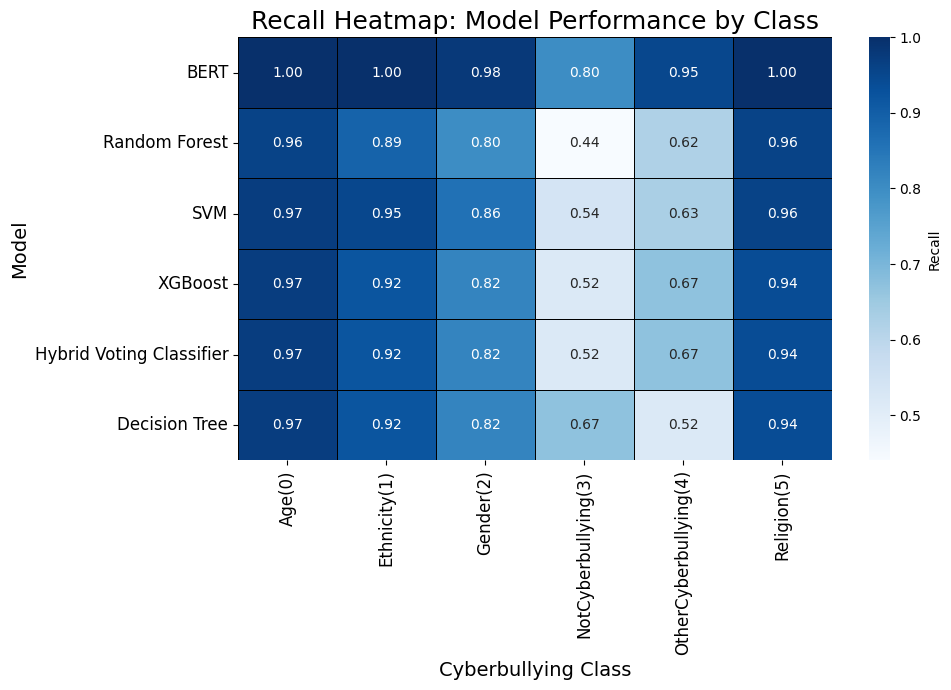

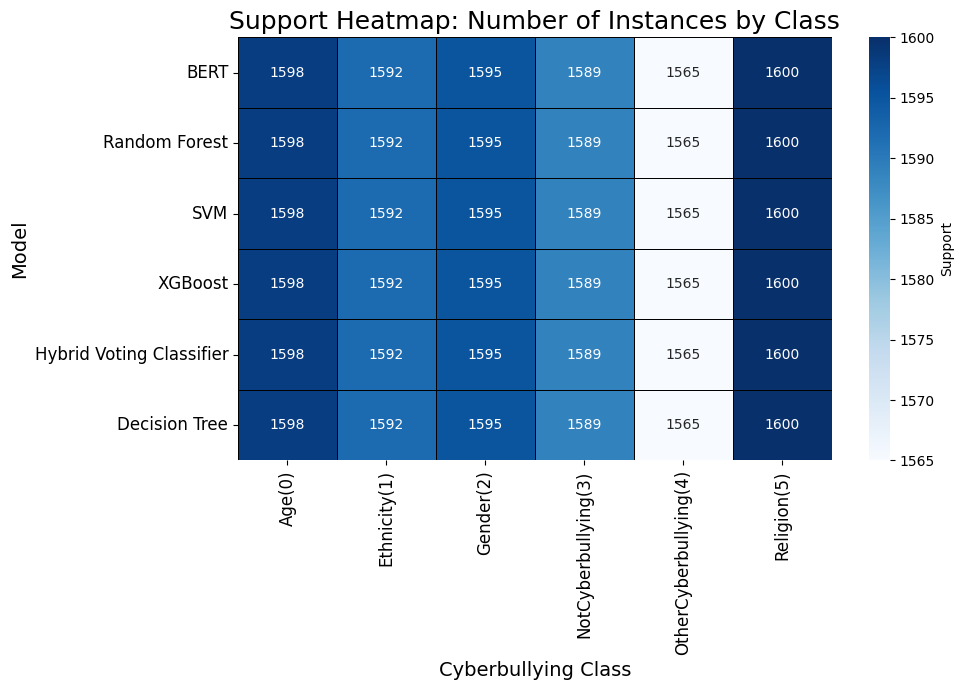

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Data from the provided table
data = {
    'Model': ['BERT','Random Forest', 'SVM', 'XGBoost', 'Hybrid Voting Classifier', 'Decision Tree' ],
    'Precision': [[1.00, 1.00, 0.97, 0.95, 0.82, 1.00],
                  [0.92, 0.96, 0.87, 0.53, 0.51, 0.90],
                  [0.98, 0.97, 0.88, 0.57, 0.57, 0.95],
                  [0.95, 0.96, 0.85, 0.58, 0.58, 0.93],
                  [0.95, 0.96, 0.85, 0.58, 0.58, 0.93],
                  [0.95, 0.96, 0.85, 0.58, 0.58, 0.93]],
    'Recall': [[1.00, 1.00, 0.98, 0.80, 0.95, 1.00],
               [0.96, 0.89, 0.80, 0.44, 0.62, 0.96],
               [0.97, 0.95, 0.86, 0.54, 0.63, 0.96],
               [0.97, 0.92, 0.82, 0.52, 0.67, 0.94],
               [0.97, 0.92, 0.82, 0.52, 0.67, 0.94],
               [0.97, 0.92, 0.82, 0.67, 0.52, 0.94]],
    'F1-Score': [[1.00, 1.00, 0.98, 0.87, 0.88, 1.00],
                 [0.94, 0.92, 0.83, 0.48, 0.56, 0.93],
                 [0.97, 0.96, 0.87, 0.55, 0.60, 0.96],
                 [0.96, 0.94, 0.84, 0.55, 0.62, 0.94],
                 [0.96, 0.94, 0.84, 0.55, 0.62, 0.94],
                 [0.96, 0.94, 0.84, 0.62, 0.55, 0.94]],
    'Support': [
    [1598,1592,1595,1589,1565,1600],
    [1598,1592,1595,1589,1565,1600],
    [1598,1592,1595,1589,1565,1600],
    [1598,1592,1595,1589,1565,1600],
    [1598,1592,1595,1589,1565,1600],
    [1598,1592,1595,1589,1565,1600]]
}

class_labels = ['Age(0)', 'Ethnicity(1)', 'Gender(2)', 'NotCyberbullying(3)', 'OtherCyberbullying(4)', 'Religion(5)']
model_order = ['BERT','Random Forest', 'SVM', 'XGBoost', 'Hybrid Voting Classifier', 'Decision Tree' ]

# Create DataFrames for each metric
df_f1 = pd.DataFrame({
    'Model': np.repeat(data['Model'], len(class_labels)),
    'Class': np.tile(class_labels, len(data['Model'])),
    'F1-Score': [score for model_scores in data['F1-Score'] for score in model_scores]
})

df_precision = pd.DataFrame({
    'Model': np.repeat(data['Model'], len(class_labels)),
    'Class': np.tile(class_labels, len(data['Model'])),
    'Precision': [score for model_scores in data['Precision'] for score in model_scores]
})

df_recall = pd.DataFrame({
    'Model': np.repeat(data['Model'], len(class_labels)),
    'Class': np.tile(class_labels, len(data['Model'])),
    'Recall': [score for model_scores in data['Recall'] for score in model_scores]
})

df_support = pd.DataFrame({
    'Model': np.repeat(data['Model'], len(class_labels)),
    'Class': np.tile(class_labels, len(data['Model'])),
    'Support': [score for model_scores in data['Support'] for score in model_scores]
})


# Create the bar plot for F1-Score comparison
plt.figure(figsize=(16, 8))
# Use df_f1 for the bar plot
sns.barplot(x='Class', y='F1-Score', hue='Model', data=df_f1, palette='tab10')
plt.title('F1-Score Comparison Across Models and Classes', fontsize=18)
plt.xlabel('Cyberbullying Class', fontsize=14)
plt.ylabel('F1-Score', fontsize=14)
plt.ylim(0.4, 1.01)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Model', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0., fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Pivot the DataFrames for heatmaps
df_f1_heatmap = df_f1.pivot_table(index='Model', columns='Class', values='F1-Score')
df_precision_heatmap = df_precision.pivot_table(index='Model', columns='Class', values='Precision') # Use df_precision here
df_recall_heatmap = df_recall.pivot_table(index='Model', columns='Class', values='Recall')     # Use df_recall here
df_support_heatmap = df_support.pivot_table(index='Model', columns='Class', values='Support')     # Use df_support here


# Reorder columns and rows for consistency
df_f1_heatmap = df_f1_heatmap[class_order].reindex(model_order)
df_precision_heatmap = df_precision_heatmap[class_order].reindex(model_order)
df_recall_heatmap = df_recall_heatmap[class_order].reindex(model_order)
df_support_heatmap = df_support_heatmap[class_order].reindex(model_order)

# Plot Heatmap for F1-Score
plt.figure(figsize=(10, 7))
sns.heatmap(df_f1_heatmap, annot=True, fmt=".2f", cmap="Blues", linewidths=.5, linecolor='black', cbar_kws={'label': 'F1-Score'})
plt.title('F1-Score Heatmap: Model Performance by Class', fontsize=18)
plt.xlabel('Cyberbullying Class', fontsize=14)
plt.ylabel('Model', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)
plt.tight_layout()
plt.show()


# Plot Heatmap for Precision
plt.figure(figsize=(10, 7))
sns.heatmap(df_precision_heatmap, annot=True, fmt=".2f", cmap="Blues", linewidths=.5, linecolor='black', cbar_kws={'label': 'Precision'})
plt.title('Precision Heatmap: Model Performance by Class', fontsize=18)
plt.xlabel('Cyberbullying Class', fontsize=14)
plt.ylabel('Model', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)
plt.tight_layout()
plt.show()

# Plot Heatmap for Recall
plt.figure(figsize=(10, 7))
sns.heatmap(df_recall_heatmap, annot=True, fmt=".2f", cmap="Blues", linewidths=".5", linecolor='black', cbar_kws={'label': 'Recall'})
plt.title('Recall Heatmap: Model Performance by Class', fontsize=18)
plt.xlabel('Cyberbullying Class', fontsize=14)
plt.ylabel('Model', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)
plt.tight_layout()
plt.show()

# Plot Heatmap for Support (Support will be the same across models for each class)
plt.figure(figsize=(10, 7))
sns.heatmap(df_support_heatmap, annot=True, fmt=".0f", cmap="Blues", linewidths=".5", linecolor='black', cbar_kws={'label': 'Support'})
plt.title('Support Heatmap: Number of Instances by Class', fontsize=18)
plt.xlabel('Cyberbullying Class', fontsize=14)
plt.ylabel('Model', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)
plt.tight_layout()
plt.show()


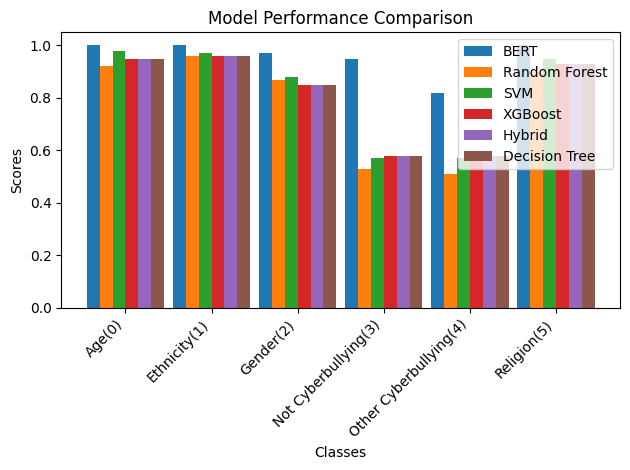

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data for visualization
models = ['BERT', 'Random Forest', 'SVM', 'XGBoost', 'Hybrid', 'Decision Tree']
classes = ['Age(0)', 'Ethnicity(1)', 'Gender(2)', 'Not Cyberbullying(3)', 'Other Cyberbullying(4)', 'Religion(5)']

# Example data for Precision, Recall, F1-Score
precision_data = [
    [1, 1, 0.97, 0.95, 0.82, 1],  # BERT
    [0.92, 0.96, 0.87, 0.53, 0.51, 0.9],  # Random Forest
    [0.98, 0.97, 0.88, 0.57, 0.57, 0.95],  # SVM
    [0.95, 0.96, 0.85, 0.58, 0.58, 0.93],  # XGBoost
    [0.95, 0.96, 0.85, 0.58, 0.58, 0.93],  # Hybrid
    [0.95, 0.96, 0.85, 0.58, 0.58, 0.93]   # Decision Tree
]

# Convert to numpy array for easier manipulation
precision_data = np.array(precision_data)

# Plotting
bar_width = 0.15
x = np.arange(len(classes))

for i in range(len(models)):
    plt.bar(x + i * bar_width, precision_data[i], width=bar_width, label=models[i])

plt.xlabel('Classes')
plt.ylabel('Scores')
plt.title('Model Performance Comparison')
# Rotate x-axis labels for readability
plt.xticks(x + bar_width * (len(models) - 1) / 2, classes, rotation=45, ha='right')
plt.legend()
plt.tight_layout() # Adjust layout to prevent labels from being cut off
plt.show()
